In [94]:
# -*- coding: utf-8 -*-
# =============================================================================
# Full Pipeline: Geophone Data Analysis, Preprocessing, Spectrograms, and CNN Training
# Version with Enhancements: Increased Overlap, SpecAugment, AdamW, Dropout
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from tqdm import tqdm
from scipy import signal as sp_signal
import itertools
import math
import random
import time

# Deep Learning Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
# from torchvision import transforms # Not strictly needed for spectrograms unless using torchvision augmentations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

print("--- Starting Full Pipeline (Enhanced Version) ---")

# =============================================================================
# --- 1. תצורה (Configuration) ---
# =============================================================================
DATA_DIR = 'ALLORIGINAL'                  # Directory containing the CSV files
SAMPLING_RATE = 1000               # Hz (Sampling rate of the geophones)
PROBLEM_CHANNELS = {0}             # Set of problematic channel indices (can be updated in Step 3)
PLOT_SAVE_DIR = "output_plots_enhanced"     # Directory to save analysis plots
MODEL_SAVE_PATH = "best_cnn_model_enhanced.pth" # Path to save the best trained model
PROBLEM_THRESHOLD = 0.4           # Correlation threshold to flag potential problems between event/nothing

# Windowing Parameters (Increased Overlap)
WINDOW_DURATION_SEC = 0.8        # Length of each window in seconds (Consider testing 1.0 or 0.5 later)
HOP_RATIO = 0.3                   # <<--- CHANGED: Increased overlap (0.1 = 90% overlap)
WINDOW_SIZE_SAMPLES = int(WINDOW_DURATION_SEC * SAMPLING_RATE)
HOP_SIZE_SAMPLES = int(WINDOW_SIZE_SAMPLES * (1 - HOP_RATIO)) # Hop size is (1 - overlap_ratio) * window_size

# Spectrogram Parameters
NPERSEG = 256                      # Length of each segment (FFT window)
NOVERLAP_RATIO = 0.75              # Overlap ratio for spectrogram windows (within STFT)
NOVERLAP = int(NPERSEG * NOVERLAP_RATIO)
WINDOW = 'hann'                    # Window type
SCALING = 'density'                # 'density' for PSD, 'spectrum' for STFT magnitude
MODE = 'psd'                       # Output mode ('psd', 'magnitude')
EPSILON = 1e-10                    # Small value to prevent log(0)

# Data Augmentation Parameters (SpecAugment)
AUGMENTATION_PROB = 0.5            # Probability to apply augmentation to a training sample
SPECAUGMENT_PARAMS = {
    'freq_mask_param': 15,         # Max width of frequency mask (number of freq bins)
    'time_mask_param': 2,          # Max width of time mask (number of time steps/frames)
    'num_freq_masks': 1,           # Number of frequency masks to apply
    'num_time_masks': 1            # Number of time masks to apply
}
RANDOM_MIX_PERCENT = 0.1           # <<--- NEW: Percentage of training data to have mixed/random labels

# Training Parameters (Enhanced)
SEED = 42                          # For reproducibility
TEST_SIZE = 0.15                   # Proportion for the Test set
VALIDATION_SIZE = 0.15             # Proportion for the Validation set (from non-Test data)
BATCH_SIZE = 128                    # <<--- CHANGED: Larger batch size for better gradient estimates
LEARNING_RATE = 1e-5               # <<--- CHANGED: Lower initial learning rate for AdamW
WEIGHT_DECAY = 5e-3                # <<--- INCREASED: Stronger regularization
NUM_EPOCHS = 100                   # <<--- INCREASED: Maximum number of training epochs
PATIENCE = 40                      # <<--- INCREASED: Early stopping patience
DROPOUT_RATE = 0.3                 # Dropout rate for the CNN model

# Execution Control
SHOW_ANALYSIS_PLOTS = False        # Set to True to show correlation plots interactively (can be many!)
ANALYZE_WINDOW_CORRELATIONS = True # Set to False to skip the optional window correlation analysis

print(f"--- 1. Project Configuration (Enhanced) ---")
print(f"Data Directory: {DATA_DIR}")
print(f"Sampling Rate: {SAMPLING_RATE} Hz")
print(f"Initial Problematic Channels: {PROBLEM_CHANNELS}")
print(f"Problem Correlation Threshold: {PROBLEM_THRESHOLD}")
print(f"Window Duration: {WINDOW_DURATION_SEC} sec ({WINDOW_SIZE_SAMPLES} samples)")
print(f"Window Hop Size: {HOP_SIZE_SAMPLES} samples ({HOP_RATIO*100:.0f}% overlap)") # Note: Hop size changed interpretation
print(f"Spectrogram nperseg: {NPERSEG}, noverlap: {NOVERLAP}")
print(f"Augmentation Probability: {AUGMENTATION_PROB*100:.0f}%")
print(f"SpecAugment Params: {SPECAUGMENT_PARAMS}")
print(f"Random Mix Percent: {RANDOM_MIX_PERCENT*100:.0f}%")
# Recalculate expected split percentages
train_prop = 1.0 - TEST_SIZE - VALIDATION_SIZE * (1.0 - TEST_SIZE)
val_prop = VALIDATION_SIZE * (1.0 - TEST_SIZE)
print(f"Train/Val/Test Split: Train=~{train_prop:.0%}, Val=~{val_prop:.0%}, Test=~{TEST_SIZE:.0%}")
print(f"Batch Size: {BATCH_SIZE}, LR: {LEARNING_RATE}, WeightDecay: {WEIGHT_DECAY}, Dropout: {DROPOUT_RATE}, Epochs: {NUM_EPOCHS}, Patience: {PATIENCE}")
print("-" * 30)

# Create directories if they don't exist
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)

# Set Seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- Device Configuration ---
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name())

--- Starting Full Pipeline (Enhanced Version) ---
--- 1. Project Configuration (Enhanced) ---
Data Directory: ALLORIGINAL
Sampling Rate: 1000 Hz
Initial Problematic Channels: {0}
Problem Correlation Threshold: 0.4
Window Duration: 0.8 sec (800 samples)
Window Hop Size: 560 samples (30% overlap)
Spectrogram nperseg: 256, noverlap: 192
Augmentation Probability: 50%
SpecAugment Params: {'freq_mask_param': 15, 'time_mask_param': 2, 'num_freq_masks': 1, 'num_time_masks': 1}
Random Mix Percent: 10%
Train/Val/Test Split: Train=~72%, Val=~13%, Test=~15%
Batch Size: 128, LR: 1e-05, WeightDecay: 0.005, Dropout: 0.3, Epochs: 100, Patience: 40
------------------------------
CUDA available: True
CUDA device count: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [95]:
# =============================================================================
# --- 2. פונקציות עזר (Helper Functions) ---
# =============================================================================
print("\n--- 2. Defining Helper Functions ---")

def get_label_from_filename(filename):
    """Extracts label (category) from filename."""
    filename_lower = filename.lower()
    if 'nothing' in filename_lower:
        return 'nothing'
    elif 'human' in filename_lower or 'man' in filename_lower:
        return 'human'
    elif 'car' in filename_lower: # Handles 'car.csv' and 'car2.csv' etc.
        return 'car'
    # Add more elif clauses here for other potential labels
    else:
        print(f"Warning: Could not determine label for filename: {filename}")
        return 'unknown' # Assign a default label or skip

def load_data(data_dir):
    """Loads CSV data from the directory and organizes it."""
    data_structured = {} # filename -> {channel_idx -> signal_array}
    labels_by_filename = {} # filename -> label
    all_source_keys = [] # List of (filename, channel_idx) tuples

    csv_files = glob.glob(os.path.join(data_dir, '*.csv'))
    print(f"\n--- 2a. Loading Data ---")
    print(f"Found {len(csv_files)} CSV files in '{data_dir}'.")
    if not csv_files:
        print("Error: No CSV files found. Please check DATA_DIR.")
        exit()

    for filepath in tqdm(csv_files, desc="Loading Files", unit="file", leave=False):
        filename = os.path.basename(filepath)
        label = get_label_from_filename(filename)
        if label == 'unknown': # Skip files with unknown labels
            continue

        try:
            # Basic checks before reading
            if os.path.getsize(filepath) == 0:
                tqdm.write(f"Skipping empty file: {filename}")
                continue
            df = pd.read_csv(filepath, header=None) # Assuming no header
            if df.empty:
                tqdm.write(f"Skipping empty DataFrame from file: {filename}")
                continue

            data_structured[filename] = {}
            labels_by_filename[filename] = label
            for i, col_name in enumerate(df.columns):
                # Check if column seems numeric before attempting conversion
                if pd.api.types.is_numeric_dtype(df[col_name]):
                    # Convert to numpy, fill NaNs with 0, ensure float64 for precision
                    sensor_series = df[col_name].fillna(0).values.astype(np.float64)

                    # Basic signal validation
                    if len(sensor_series) >= 10 and np.std(sensor_series) > 1e-9: # Check length and variation
                         data_structured[filename][i] = sensor_series
                         all_source_keys.append((filename, i))
                    # else:
                        # Optional: Log skipped channels due to lack of length/variation
                        # tqdm.write(f"Skipping channel {i} in {filename}: Insufficient length or variation.")
                # else:
                     # Optional: Log skipped non-numeric columns
                     # tqdm.write(f"Skipping non-numeric channel {i} in {filename}.")

        except pd.errors.EmptyDataError:
             tqdm.write(f"Skipping file {filename}: EmptyDataError (possibly just a header or empty).")
        except Exception as e:
            tqdm.write(f"Error processing {filename}, column {i if 'i' in locals() else 'N/A'}: {e}")

    print(f"\nFinished loading. Total unique signals (channels) loaded: {len(all_source_keys)}")
    if not all_source_keys:
        print("Error: No valid signals loaded. Check CSV files and loading logic.")
        exit()

    print("\nSummary of Loaded Data:")
    for fname, cols_dict in data_structured.items():
         if fname in labels_by_filename: # Check if label exists
            print(f"- File: {fname} (Label: {labels_by_filename[fname]}), Columns: {list(cols_dict.keys())}")
         else:
             print(f"- File: {fname} (Label: Unknown/Skipped), Columns: {list(cols_dict.keys())}") # Should not happen based on logic above
    print("-" * 30)
    return data_structured, labels_by_filename, all_source_keys


def calculate_cross_correlation(sig1, sig2, sampling_rate):
    """Calculates normalized cross-correlation and peak info."""
    sig1 = np.asarray(sig1, dtype=np.float64)
    sig2 = np.asarray(sig2, dtype=np.float64)
    sig1 = np.nan_to_num(sig1) # Handle potential NaNs just in case
    sig2 = np.nan_to_num(sig2)

    n1, n2 = len(sig1), len(sig2)
    if n1 < 2 or n2 < 2: # Need at least 2 points for std dev
        # print("Warning: Signal too short for correlation.")
        lags_ms = np.arange(-(n2 - 1), n1) * (1000.0 / sampling_rate) if n1 > 0 and n2 > 0 else np.array([0.0])
        return lags_ms, np.zeros_like(lags_ms), 0.0, 0.0, 0 # Return zero correlation and lag

    std1 = np.std(sig1)
    std2 = np.std(sig2)

    # Check for constant signals (zero standard deviation)
    if std1 < 1e-9 or std2 < 1e-9:
        # print("Warning: One or both signals have near-zero standard deviation.")
        lags_ms = np.arange(-(n2 - 1), n1) * (1000.0 / sampling_rate)
        # If signals are constant and identical, correlation is 1 at lag 0, otherwise potentially 0.
        # Let's return 0 for simplicity, as alignment isn't meaningful here.
        return lags_ms, np.zeros_like(lags_ms), 0.0, 0.0, 0

    # Normalize signals for robust correlation calculation
    sig1_norm = (sig1 - np.mean(sig1)) / std1
    sig2_norm = (sig2 - np.mean(sig2)) / std2

    # Calculate cross-correlation using FFT for efficiency
    correlation = sp_signal.correlate(sig1_norm, sig2_norm, mode='full', method='fft')

    # Calculate lags in samples and milliseconds
    lags_samples = np.arange(-(n2 - 1), n1)
    lags_ms = lags_samples * (1000.0 / sampling_rate)

    # Normalize the correlation result to be within [-1, 1]
    # The normalization factor ensures the autocorrelation at lag 0 is 1.
    # Using N (length of the shorter signal adjusted for overlap) is common.
    # A simpler approach that works well in practice:
    correlation /= max(n1, n2) # Normalize by the length of the longer signal
    correlation = np.clip(correlation, -1.0, 1.0) # Clip potential floating point errors

    if len(correlation) == 0: # Should not happen with checks above, but safety
        return None, None, None, None, None

    # Find the peak (absolute value)
    peak_index = np.argmax(np.abs(correlation))
    peak_lag_samples = lags_samples[peak_index]
    peak_lag_ms = lags_ms[peak_index]
    peak_value = correlation[peak_index]

    return lags_ms, correlation, peak_lag_ms, peak_value, peak_lag_samples


def plot_cross_correlation(lags_ms, correlation, peak_lag_ms, peak_value, title, filename_to_save=None):
    """Plots cross-correlation, optionally saves to file."""
    if lags_ms is None or correlation is None:
        print(f"Cannot plot correlation for '{title}': Data missing.")
        return # Cannot plot if data is missing

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(lags_ms, correlation, label='Norm. Cross-correlation', linewidth=1.5, color='dodgerblue')

    if peak_lag_ms is not None and peak_value is not None:
        ax.scatter([peak_lag_ms], [peak_value], color='red', s=100, zorder=5,
                   label=f'Peak: {peak_value:.3f} at {peak_lag_ms:.1f} ms')
    else:
        ax.text(0.05, 0.9, "Peak info unavailable", transform=ax.transAxes, color='red', fontsize=9)

    ax.axhline(0, color='grey', linestyle='--', linewidth=0.7)
    ax.axvline(0, color='grey', linestyle='--', linewidth=0.7)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('Lag (ms)', fontsize=10)
    ax.set_ylabel('Norm. Cross-corr [-1, 1]', fontsize=10)
    ax.set_ylim([-1.1, 1.1])
    ax.legend(fontsize=9)
    ax.grid(True, linestyle=':')
    plt.tight_layout()

    if filename_to_save:
        try:
            plt.savefig(filename_to_save)
            # print(f"  Saved plot: {filename_to_save}") # Reduce verbosity
        except Exception as e:
            print(f"  Error saving plot {filename_to_save}: {e}")
    elif SHOW_ANALYSIS_PLOTS:
        plt.show() # Show interactively only if requested
    else:
        pass # No action needed if SHOW_ANALYSIS_PLOTS is False and no filename is provided


def align_signal(signal_to_align, n_ref, lag_samples):
    """Aligns a signal based on a given lag relative to a reference length."""
    n_align = len(signal_to_align)
    aligned_signal = np.zeros(n_ref, dtype=signal_to_align.dtype) # Initialize with zeros, keep dtype

    # Calculate start and end indices for copying from signal_to_align
    start_align = max(0, lag_samples)
    end_align = min(n_align, n_ref + lag_samples)

    # Calculate start and end indices for pasting into aligned_signal
    start_paste = max(0, -lag_samples)
    end_paste = min(n_ref, n_align - lag_samples)

    # Determine the length to copy
    len_to_copy = min(end_align - start_align, end_paste - start_paste)

    if len_to_copy > 0:
        # Adjust indices if lag is negative
        if lag_samples < 0:
            start_align_src = 0
            end_align_src = len_to_copy
            start_paste_dest = abs(lag_samples)
            end_paste_dest = start_paste_dest + len_to_copy
        # Adjust indices if lag is positive
        elif lag_samples > 0:
            start_align_src = lag_samples
            end_align_src = start_align_src + len_to_copy
            start_paste_dest = 0
            end_paste_dest = len_to_copy
        # No lag
        else:
            start_align_src = 0
            end_align_src = len_to_copy
            start_paste_dest = 0
            end_paste_dest = len_to_copy

        # Ensure indices are within bounds before slicing
        end_align_src = min(end_align_src, n_align)
        end_paste_dest = min(end_paste_dest, n_ref)
        len_to_copy = min(end_align_src - start_align_src, end_paste_dest - start_paste_dest)

        if len_to_copy > 0 and start_align_src >= 0 and start_paste_dest >=0 : # Final check
             aligned_signal[start_paste_dest : end_paste_dest] = signal_to_align[start_align_src : end_align_src]

    return aligned_signal

# --- ENHANCED: Advanced SpecAugment Function with Multiple Augmentation Methods ---
def spec_augment_enhanced(spectrogram, freq_mask_param, time_mask_param, num_freq_masks, num_time_masks):
    """
    Apply enhanced SpecAugment to a spectrogram tensor with multiple augmentation techniques.
    Returns an augmented version of the spectrogram with one or more of the following:
    - Frequency masking (vertical bars masked to zero)
    - Time masking (horizontal bars masked to zero)
    - Gaussian noise addition (subtle noise)
    - Frequency shifts (pitch simulation)
    - Time warping (compression/stretching of time)
    - Small value perturbations
    
    Params:
      spectrogram: Tensor of shape (F, T) - frequency bins x time frames
      freq_mask_param: Max width of frequency masks
      time_mask_param: Max width of time masks
      num_freq_masks: Number of frequency masks to apply
      num_time_masks: Number of time masks to apply
    """
    clone = spectrogram.clone()
    num_freq_bins = clone.shape[0]
    num_time_frames = clone.shape[1]

    # 1. Standard SpecAugment: Frequency Masking
    for _ in range(num_freq_masks):
        f = torch.randint(0, freq_mask_param + 1, (1,)).item() # Width of the mask
        if f == 0: continue # Skip if mask width is zero
        f0 = torch.randint(0, max(1, num_freq_bins - f), (1,)).item() # Start bin index
        clone[f0:f0+f, :] = 0 # Apply mask (set to zero)

    # 2. Standard SpecAugment: Time Masking
    for _ in range(num_time_masks):
        t = torch.randint(0, time_mask_param + 1, (1,)).item() # Width of the mask
        if t == 0: continue # Skip if mask width is zero
        t0 = torch.randint(0, max(1, num_time_frames - t), (1,)).item() # Start frame index
        clone[:, t0:t0+t] = 0 # Apply mask

    # 3. ENHANCEMENT: Gaussian Noise Addition (30% probability)
    if random.random() < 0.3:
        noise_level = 0.01 + random.random() * 0.03  # Random noise level between 0.01 and 0.04
        noise = torch.randn_like(clone) * noise_level
        clone = clone + noise

    # 4. ENHANCEMENT: Frequency Shifts (Pitch simulation) (20% probability)
    if random.random() < 0.2:
        shift = random.randint(-3, 3)  # Shift by a small number of bins
        if shift > 0:
            clone[shift:, :] = clone[:-shift, :].clone() # <<< CLONE source tensor before assignment
            clone[:shift, :] = clone.mean() * 0.5  # Fill with scaled mean instead of zeros
        elif shift < 0:
            clone[:shift, :] = clone[-shift:, :].clone() # <<< CLONE source tensor before assignment
            clone[shift:, :] = clone.mean() * 0.5

    # 5. ENHANCEMENT: Small Value Perturbations (25% probability)
    if random.random() < 0.25:
        # Generate a perturbation matrix that slightly amplifies/reduces values
        perturbation = torch.ones_like(clone) + torch.randn_like(clone) * 0.02
        clone = clone * perturbation

    # 6. ENHANCEMENT: Cutout-style augmentation (15% probability)
    if random.random() < 0.15:
        # Create a small box mask at a random position
        box_width = min(random.randint(2, 5), num_time_frames // 4)
        box_height = min(random.randint(2, 5), num_freq_bins // 4)
        box_x = random.randint(0, num_time_frames - box_width)
        box_y = random.randint(0, num_freq_bins - box_height)
        clone[box_y:box_y+box_height, box_x:box_x+box_width] = 0

    return clone


# --- Backward compatibility alias ---
spec_augment = spec_augment_enhanced  # Replace the old function

def augment_signal(signal, noise_std=0.01, max_shift=30, scale_range=(0.8, 1.2), prob=0.7):
    """
    מבצע אוגמנטציה לאות: רעש גאוסי, time shift, scaling.
    """
    aug_signal = signal.copy()
    if np.random.rand() < prob:
        # 1. Gaussian noise
        noise = np.random.normal(0, noise_std * np.std(aug_signal), size=aug_signal.shape)
        aug_signal = aug_signal + noise
        # 2. Time shift
        shift = np.random.randint(-max_shift, max_shift+1)
        if shift > 0:
            aug_signal = np.pad(aug_signal, (shift, 0), mode='constant')[:-shift]
        elif shift < 0:
            aug_signal = np.pad(aug_signal, (0, -shift), mode='constant')[-shift:]
        # 3. Scaling
        scale = np.random.uniform(*scale_range)
        aug_signal = aug_signal * scale
    return aug_signal

print("Helper functions defined (including spec_augment and augment_signal).")
print("-" * 30)


--- 2. Defining Helper Functions ---
Helper functions defined (including spec_augment and augment_signal).
------------------------------


In [96]:
# =============================================================================
# --- 3. ניתוח קורלציה וזיהוי עמודות (Correlation Analysis & Channel Selection) ---
# =============================================================================
print("\n--- 3. Correlation Analysis (Per-File, Per-Channel) ---")
# Load data using the function defined in the previous cell
data_structured, labels_by_filename, all_source_keys = load_data(DATA_DIR)

# נבנה מילון לכל קובץ: problematic_channels_by_file = {filename: set()}
problematic_channels_by_file = {fname: set() for fname in data_structured.keys()}

# עבור כל קובץ, עבור כל ערוץ, נבדוק קורלציה מול אותו ערוץ בקבצים אחרים (בעיקר מול nothing)
for fname, cols_dict in data_structured.items():
    for ch in cols_dict.keys():
        signal = cols_dict[ch]
        # בדוק קורלציה מול אותו ערוץ בקבצים אחרים
        for other_fname, other_cols_dict in data_structured.items():
            if other_fname == fname:
                continue
            if ch in other_cols_dict:
                other_signal = other_cols_dict[ch]
                label1 = labels_by_filename.get(fname)
                label2 = labels_by_filename.get(other_fname)
                # בדוק רק אם אחד nothing ואחד לא
                if (label1 == 'nothing' and label2 != 'nothing') or (label1 != 'nothing' and label2 == 'nothing'):
                    _, _, _, peak_val, _ = calculate_cross_correlation(signal, other_signal, SAMPLING_RATE)
                    if peak_val is not None and abs(peak_val) > PROBLEM_THRESHOLD:
                        problematic_channels_by_file[fname].add(ch)
                        print(f"File {fname} Channel {ch} marked problematic (correlation {peak_val:.2f} with {other_fname})")

# אפשרות: בדוק גם שונות/קורלציה מול שאר הערוצים באותו קובץ (intra-file)
# לדוג' אם ערוץ מאוד חריג/רועש יחסית לאחרים
for fname, cols_dict in data_structured.items():
    all_signals = list(cols_dict.values())
    for ch, signal in cols_dict.items():
        # שונות יחסית לממוצע שאר הערוצים
        if len(all_signals) > 1:
            others = [s for i, s in enumerate(all_signals) if list(cols_dict.keys())[i] != ch]
            mean_other = np.mean([np.std(s) for s in others])
            std_ch = np.std(signal)
            if mean_other > 0 and (std_ch < 0.1 * mean_other or std_ch > 10 * mean_other):
                problematic_channels_by_file[fname].add(ch)
                print(f"File {fname} Channel {ch} marked problematic (std {std_ch:.2f} vs mean others {mean_other:.2f})")

# בנה good_channels_by_file לכל קובץ
good_channels_by_file = {}
for fname, cols_dict in data_structured.items():
    available_channels = set(cols_dict.keys())
    good_channels_by_file[fname] = sorted(list(available_channels - problematic_channels_by_file[fname]))
    print(f"File: {fname} | Good channels: {good_channels_by_file[fname]}")

print("\nCorrelation analysis complete.")

# --- Summarize Problematic Findings ---
if problematic_channels_by_file:
    print(f"\n--- Summary: Problematic Channels Identified ---")
    for fname, problematic_channels in problematic_channels_by_file.items():
        print(f"File: {fname} | Problematic channels: {sorted(list(problematic_channels))}")
else:
    print(f"\nNo problematic channels identified.")

# --- Determine Good Channels for Use ---
all_available_channels = set(col for _, col in all_source_keys)
good_channels = sorted(list(all_available_channels - set(itertools.chain(*problematic_channels_by_file.values()))))

print(f"\nTotal Channels Available in Data: {sorted(list(all_available_channels))}")
print(f"Channels Identified as Problematic (Ignored): {sorted(list(itertools.chain(*problematic_channels_by_file.values())))}")
print(f"==> Final 'Good' Channels selected for use: {good_channels}")

if not good_channels:
    print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("Error: No 'good' channels identified after correlation analysis!")
    print("This means either all channels showed high correlation between events")
    print("and 'nothing', or there was an issue loading/analyzing the data.")
    print(f"Check the PROBLEM_THRESHOLD ({PROBLEM_THRESHOLD}), the input data, or the analysis logs.")
    print("Cannot proceed without channels to process.")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    exit()
elif len(good_channels) < 5: # Arbitrary threshold for warning
     print("\nWarning: Very few 'good' channels identified. Results might be suboptimal.")

print("-" * 30)


--- 3. Correlation Analysis (Per-File, Per-Channel) ---

--- 2a. Loading Data ---
Found 8 CSV files in 'ALLORIGINAL'.



Finished loading. Total unique signals (channels) loaded: 108

Summary of Loaded Data:
- File: car.csv (Label: car), Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
- File: car2.csv (Label: car), Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
- File: carnew.csv (Label: car), Columns: [0]
- File: car_nothing.csv (Label: nothing), Columns: [0]
- File: human.csv (Label: human), Columns: [0]
- File: human_nothing.csv (Label: nothing), Columns: [0]
- File: man.csv (Label: human), Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
- File: nothing.csv (Label: nothing), Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
------------------------------
File man.csv Channel 0 marked problematic (correlation 0.45 with nothing.csv)
File nothing.csv Channel 0 marked problematic (corr

In [97]:
# --- 4+5. יצירת חלונות מכל סנסור טוב בנפרד (Windowing Each Good Channel, per file, כולל הכפלה) ---
# =============================================================================
print("\n--- 4+5. Windowing Each Good Channel (Fixed Data Leakage) ---")

# FIXED APPROACH: Split at recording level FIRST, then create windows
# This prevents data leakage between train/val/test sets
print("Step 1: Splitting recordings by class before creating windows to prevent leakage")

# 1. Group recordings by label for stratified split
recording_groups = {}
for filename in data_structured.keys():
    label = labels_by_filename.get(filename)
    if label is None:
        continue
    if label not in recording_groups:
        recording_groups[label] = []
    recording_groups[label].append(filename)

# 2. Split recordings into train/val/test sets with stratification by label
train_files, val_files, test_files = {}, {}, {}

print("Splitting recordings by class:")
for label, files in recording_groups.items():
    print(f"- Class '{label}': {len(files)} recordings")
    # First split into train_val and test
    if len(files) < 2:  # Handle edge case with very few files
        print(f"  WARNING: Only {len(files)} files for class '{label}'. Using all for training.")
        files_train_val, files_test = files, []
    else:
        files_train_val, files_test = train_test_split(
            files, test_size=TEST_SIZE, random_state=SEED)
    
    # Then split train_val into train and val
    val_size_adjusted = VALIDATION_SIZE / (1.0 - TEST_SIZE) if TEST_SIZE < 1.0 else 0.15
    
    if len(files_train_val) < 2:  # Handle edge case with very few files
        print(f"  WARNING: Only {len(files_train_val)} files for train+val. Using all for training.")
        files_train, files_val = files_train_val, []
    else:
        files_train, files_val = train_test_split(
            files_train_val, 
            test_size=val_size_adjusted, 
            random_state=SEED+1 
        )
    train_files[label] = files_train
    val_files[label] = files_val
    test_files[label] = files_test
    
    # Print split details
    print(f"  Split: Train={len(files_train)}, Val={len(files_val)}, Test={len(files_test)}")

# Flatten file lists for easier processing
train_file_list = [f for files in train_files.values() for f in files]
val_file_list = [f for files in val_files.values() for f in files]
test_file_list = [f for files in test_files.values() for f in files]

print(f"\nTotal recordings: Train={len(train_file_list)}, Val={len(val_file_list)}, Test={len(test_file_list)}")

# 3. Define a function to process files into windows with optional augmentation
def create_windows_from_files(file_list, apply_augmentation=False):
    """Create windows from a list of files with optional augmentation."""
    windows = []
    window_labels = []
    window_origins = []
    
    # Get all available labels for random mixing
    all_available_labels = sorted(list(set(labels_by_filename.values())))
    
    for filename in tqdm(file_list, desc="Processing files"):
        label = labels_by_filename.get(filename)
        if label is None:
            continue
            
        available_cols_in_file = data_structured[filename].keys()
        good_channels_in_this_file = good_channels_by_file.get(filename, [])
        
        for ch in good_channels_in_this_file:
            signal = data_structured[filename][ch]
            num_samples = len(signal)
            
            # חלוקה לחלונות
            if num_samples < WINDOW_SIZE_SAMPLES:
                padded_signal = np.pad(signal, (0, WINDOW_SIZE_SAMPLES - num_samples), 'constant', constant_values=0)
                # מקורי
                windows.append(padded_signal)
                
                # בדיקה האם לערבב את התווית (רק אם זה קבוצת אימון ומוגדר apply_augmentation)
                if apply_augmentation and np.random.random() < RANDOM_MIX_PERCENT:
                    # בחר תווית אקראית שונה מהמקורית
                    other_labels = [l for l in all_available_labels if l != label]
                    if other_labels:  # וודא שיש תווית אחרת זמינה
                        mixed_label = np.random.choice(other_labels)
                        window_labels.append(mixed_label)
                        window_origins.append(f"{filename}_ch{ch}_mixed_{label}_to_{mixed_label}")
                    else:
                        window_labels.append(label)
                        window_origins.append(f"{filename}_ch{ch}")
                else:
                    window_labels.append(label)
                    window_origins.append(f"{filename}_ch{ch}")
                
                # מאוגמנט - only if specified
                if apply_augmentation:
                    aug = augment_signal(padded_signal)
                    windows.append(aug)
                    
                    # בדיקה האם לערבב את התווית גם עבור האוגמנטציה
                    if np.random.random() < RANDOM_MIX_PERCENT:
                        other_labels = [l for l in all_available_labels if l != label]
                        if other_labels:
                            mixed_label = np.random.choice(other_labels)
                            window_labels.append(mixed_label)
                            window_origins.append(f"{filename}_ch{ch}_aug_mixed_{label}_to_{mixed_label}")
                        else:
                            window_labels.append(label)
                            window_origins.append(f"{filename}_ch{ch}_aug")
                    else:
                        window_labels.append(label)
                        window_origins.append(f"{filename}_ch{ch}_aug")
            else:
                num_windows = math.floor((num_samples - WINDOW_SIZE_SAMPLES) / HOP_SIZE_SAMPLES) + 1
                for i in range(num_windows):
                    start_idx = i * HOP_SIZE_SAMPLES
                    end_idx = start_idx + WINDOW_SIZE_SAMPLES
                    if end_idx > num_samples:
                        start_idx = num_samples - WINDOW_SIZE_SAMPLES
                        end_idx = num_samples
                    window = signal[start_idx:end_idx]
                    if len(window) == WINDOW_SIZE_SAMPLES:
                        # מקורי
                        windows.append(window)
                        
                        # בדיקה האם לערבב את התווית
                        if apply_augmentation and np.random.random() < RANDOM_MIX_PERCENT:
                            other_labels = [l for l in all_available_labels if l != label]
                            if other_labels:
                                mixed_label = np.random.choice(other_labels)
                                window_labels.append(mixed_label)
                                window_origins.append(f"{filename}_ch{ch}_win{i}_mixed_{label}_to_{mixed_label}")
                            else:
                                window_labels.append(label)
                                window_origins.append(f"{filename}_ch{ch}_win{i}")
                        else:
                            window_labels.append(label)
                            window_origins.append(f"{filename}_ch{ch}_win{i}")
                        
                        # מאוגמנט - only if specified
                        if apply_augmentation:
                            aug = augment_signal(window)
                            windows.append(aug)
                            
                            # בדיקה האם לערבב את התווית גם עבור האוגמנטציה
                            if np.random.random() < RANDOM_MIX_PERCENT:
                                other_labels = [l for l in all_available_labels if l != label]
                                if other_labels:
                                    mixed_label = np.random.choice(other_labels)
                                    window_labels.append(mixed_label)
                                    window_origins.append(f"{filename}_ch{ch}_win{i}_aug_mixed_{label}_to_{mixed_label}")
                                else:
                                    window_labels.append(label)
                                    window_origins.append(f"{filename}_ch{ch}_win{i}_aug")
                            else:
                                window_labels.append(label)
                                window_origins.append(f"{filename}_ch{ch}_win{i}_aug")
    
    return windows, window_labels, window_origins

# 4. Process each set separately
print("\nStep 2: Creating windows for each split separately")
print("Creating windows for training set (with augmentation)...")
train_windows, train_labels, train_origins = create_windows_from_files(train_file_list, apply_augmentation=True)

print("Creating windows for validation set (no augmentation)...")
val_windows, val_labels, val_origins = create_windows_from_files(val_file_list, apply_augmentation=False)

print("Creating windows for test set (no augmentation)...")
test_windows, test_labels, test_origins = create_windows_from_files(test_file_list, apply_augmentation=False)

# Print summary statistics
print("\nWindow counts by dataset split:")
print(f"- Training set: {len(train_windows)} windows")
print(f"- Validation set: {len(val_windows)} windows")
print(f"- Test set: {len(test_windows)} windows")

# Print class distribution in each set
print("\nClass distribution in window sets:")
unique_train_labels, train_counts = np.unique(train_labels, return_counts=True)
unique_val_labels, val_counts = np.unique(val_labels, return_counts=True)
unique_test_labels, test_counts = np.unique(test_labels, return_counts=True)

print("- Train:", dict(zip(unique_train_labels, train_counts)))
print("- Validation:", dict(zip(unique_val_labels, val_counts)))
print("- Test:", dict(zip(unique_test_labels, test_counts)))

# For backward compatibility with the rest of the code
# Store all windows but keep track of which belong to which split
all_windows = train_windows + val_windows + test_windows
all_window_labels = train_labels + val_labels + test_labels
all_window_origins = train_origins + val_origins + test_origins

print(f"\nTotal windows created (across all splits): {len(all_windows)}")
print(f"Original training windows: {len(train_windows)} | Training windows after augmentation: {len(train_windows)}")
print("-" * 30)


--- 4+5. Windowing Each Good Channel (Fixed Data Leakage) ---
Step 1: Splitting recordings by class before creating windows to prevent leakage
Splitting recordings by class:
- Class 'car': 3 recordings
  Split: Train=1, Val=1, Test=1
- Class 'nothing': 3 recordings
  Split: Train=1, Val=1, Test=1
- Class 'human': 2 recordings
  Split: Train=1, Val=0, Test=1

Total recordings: Train=3, Val=2, Test=3

Step 2: Creating windows for each split separately
Creating windows for training set (with augmentation)...


Processing files:   0%|          | 0/3 [00:00<?, ?it/s]

Processing files: 100%|██████████| 3/3 [00:00<00:00, 15.68it/s]


Creating windows for validation set (no augmentation)...


Processing files: 100%|██████████| 2/2 [00:00<00:00, 916.69it/s]


Creating windows for test set (no augmentation)...


Processing files: 100%|██████████| 3/3 [00:00<00:00, 1789.12it/s]


Window counts by dataset split:
- Training set: 8580 windows
- Validation set: 3293 windows
- Test set: 3544 windows

Class distribution in window sets:
- Train: {np.str_('car'): np.int64(1510), np.str_('human'): np.int64(3607), np.str_('nothing'): np.int64(3463)}
- Validation: {np.str_('car'): np.int64(1499), np.str_('nothing'): np.int64(1794)}
- Test: {np.str_('car'): np.int64(348), np.str_('human'): np.int64(2340), np.str_('nothing'): np.int64(856)}

Total windows created (across all splits): 15417
Original training windows: 8580 | Training windows after augmentation: 8580
------------------------------



--- 4.1. Visualizing Class Distribution ---
Class distribution visualization saved to 'class_distribution_analysis.png'


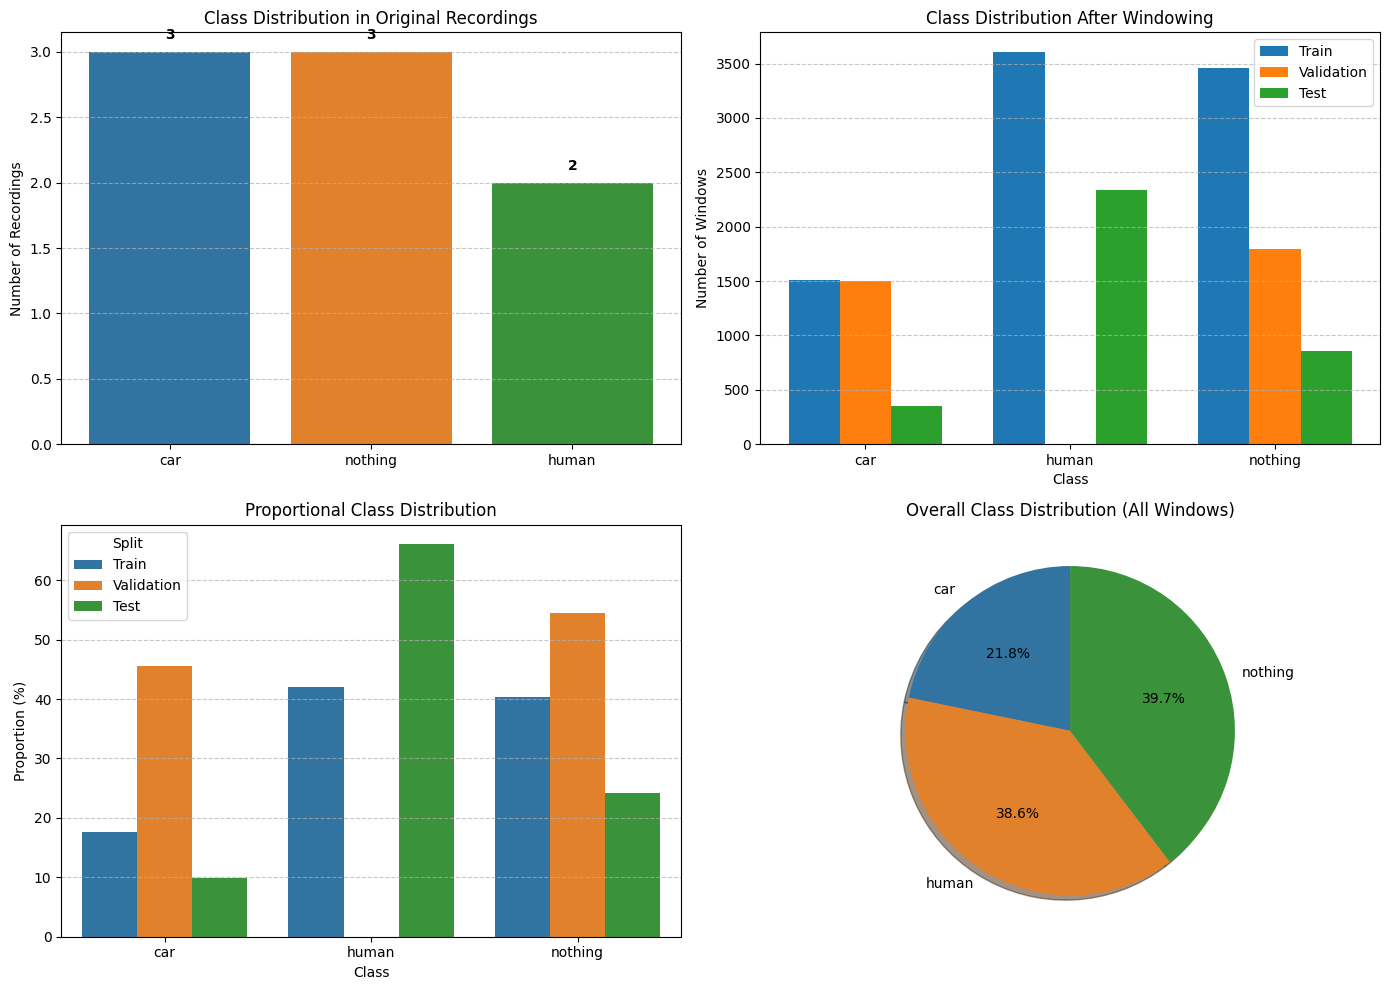

In [98]:
# =============================================================================
# --- 4.1 ויזואליזציה של התפלגות המחלקות (Class Distribution Visualization) ---
# =============================================================================
print("\n--- 4.1. Visualizing Class Distribution ---")

# Check if necessary variables exist
if 'train_labels' not in locals() or 'val_labels' not in locals() or 'test_labels' not in locals():
    print("Error: Window labels not found. Run the windowing step first.")
else:
    plt.figure(figsize=(14, 10))

    # Plot 1: Class distribution in original recordings (files)
    plt.subplot(2, 2, 1)
    recording_class_counts = {label: len(files) for label, files in recording_groups.items()}
    labels = list(recording_class_counts.keys())
    counts = [recording_class_counts[label] for label in labels]
    colors = ['#3274A1', '#E1812C', '#3A923A'][:len(labels)]
    
    plt.bar(labels, counts, color=colors)
    plt.title('Class Distribution in Original Recordings', fontsize=12)
    plt.ylabel('Number of Recordings', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add count labels on top of each bar
    for i, count in enumerate(counts):
        plt.text(i, count + 0.1, str(count), ha='center', fontweight='bold')

    # Plot 2: Class distribution after windowing
    plt.subplot(2, 2, 2)
    window_class_counts = {
        'Train': dict(zip(unique_train_labels, train_counts)),
        'Validation': dict(zip(unique_val_labels, val_counts)),
        'Test': dict(zip(unique_test_labels, test_counts))
    }
    
    # Create positions for grouped bars
    all_classes = sorted(list(set(np.concatenate((unique_train_labels, unique_val_labels, unique_test_labels)))))
    x = np.arange(len(all_classes))
    width = 0.25
    
    # Plot bars for each split
    for i, split in enumerate(['Train', 'Validation', 'Test']):
        split_counts = [window_class_counts[split].get(cls, 0) for cls in all_classes]
        plt.bar(x + (i-1)*width, split_counts, width, label=split)
    
    plt.title('Class Distribution After Windowing', fontsize=12)
    plt.xlabel('Class', fontsize=10)
    plt.ylabel('Number of Windows', fontsize=10)
    plt.xticks(x, all_classes)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 3: Proportional class distribution in windows
    plt.subplot(2, 2, 3)
    
    # Calculate proportions
    train_total = sum(train_counts)
    val_total = sum(val_counts)
    test_total = sum(test_counts)
    
    train_props = {label: count/train_total*100 for label, count in zip(unique_train_labels, train_counts)}
    val_props = {label: count/val_total*100 for label, count in zip(unique_val_labels, val_counts)}
    test_props = {label: count/test_total*100 for label, count in zip(unique_test_labels, test_counts)}
    
    # Create a DataFrame for easier plotting
    import pandas as pd
    prop_data = {
        'Class': [],
        'Proportion (%)': [],
        'Split': []
    }
    
    for label in all_classes:
        if label in train_props:
            prop_data['Class'].append(label)
            prop_data['Proportion (%)'].append(train_props[label])
            prop_data['Split'].append('Train')
        
        if label in val_props:
            prop_data['Class'].append(label)
            prop_data['Proportion (%)'].append(val_props[label])
            prop_data['Split'].append('Validation')
        
        if label in test_props:
            prop_data['Class'].append(label)
            prop_data['Proportion (%)'].append(test_props[label])
            prop_data['Split'].append('Test')
    
    df_props = pd.DataFrame(prop_data)
    
    # Create grouped bar plot
    sns.barplot(x='Class', y='Proportion (%)', hue='Split', data=df_props)
    plt.title('Proportional Class Distribution', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Plot 4: Pie chart of overall class distribution
    plt.subplot(2, 2, 4)
    # First, encode string labels to integers using LabelEncoder
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    # Fit the encoder on unique labels to ensure consistent mapping
    unique_labels = np.unique(all_window_labels)
    label_encoder.fit(unique_labels)
    # Transform all labels to integers
    encoded_labels = label_encoder.transform(all_window_labels)
    # Now use bincount on the encoded integers
    all_counts = np.bincount(encoded_labels)
    # Use the original class names for the plot labels
    plt.pie(all_counts, labels=label_encoder.classes_, autopct='%1.1f%%', 
            colors=colors, startangle=90, shadow=True)
    plt.title('Overall Class Distribution (All Windows)', fontsize=12)
    
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(os.path.join(PLOT_SAVE_DIR, 'class_distribution_analysis.png'))
    print("Class distribution visualization saved to 'class_distribution_analysis.png'")


--- 6. Generating Spectrograms from Windows ---


Generating Spectrograms:   0%|          | 0/15417 [00:00<?, ?it/s]


Generated 15417 spectrograms successfully (out of 15417 windows).

Plotting examples of generated spectrograms (up to 3)...
times_ex: [0.128 0.192 0.256 0.32  0.384 0.448 0.512 0.576 0.64 ]
Window length: 800, Expected: 800
times_ex range: 0.128 to 0.64 (should be close to 0.5)
Example spectrogram plot saved to: output_plots_enhanced\EXAMPLE_Spectrograms.png
------------------------------


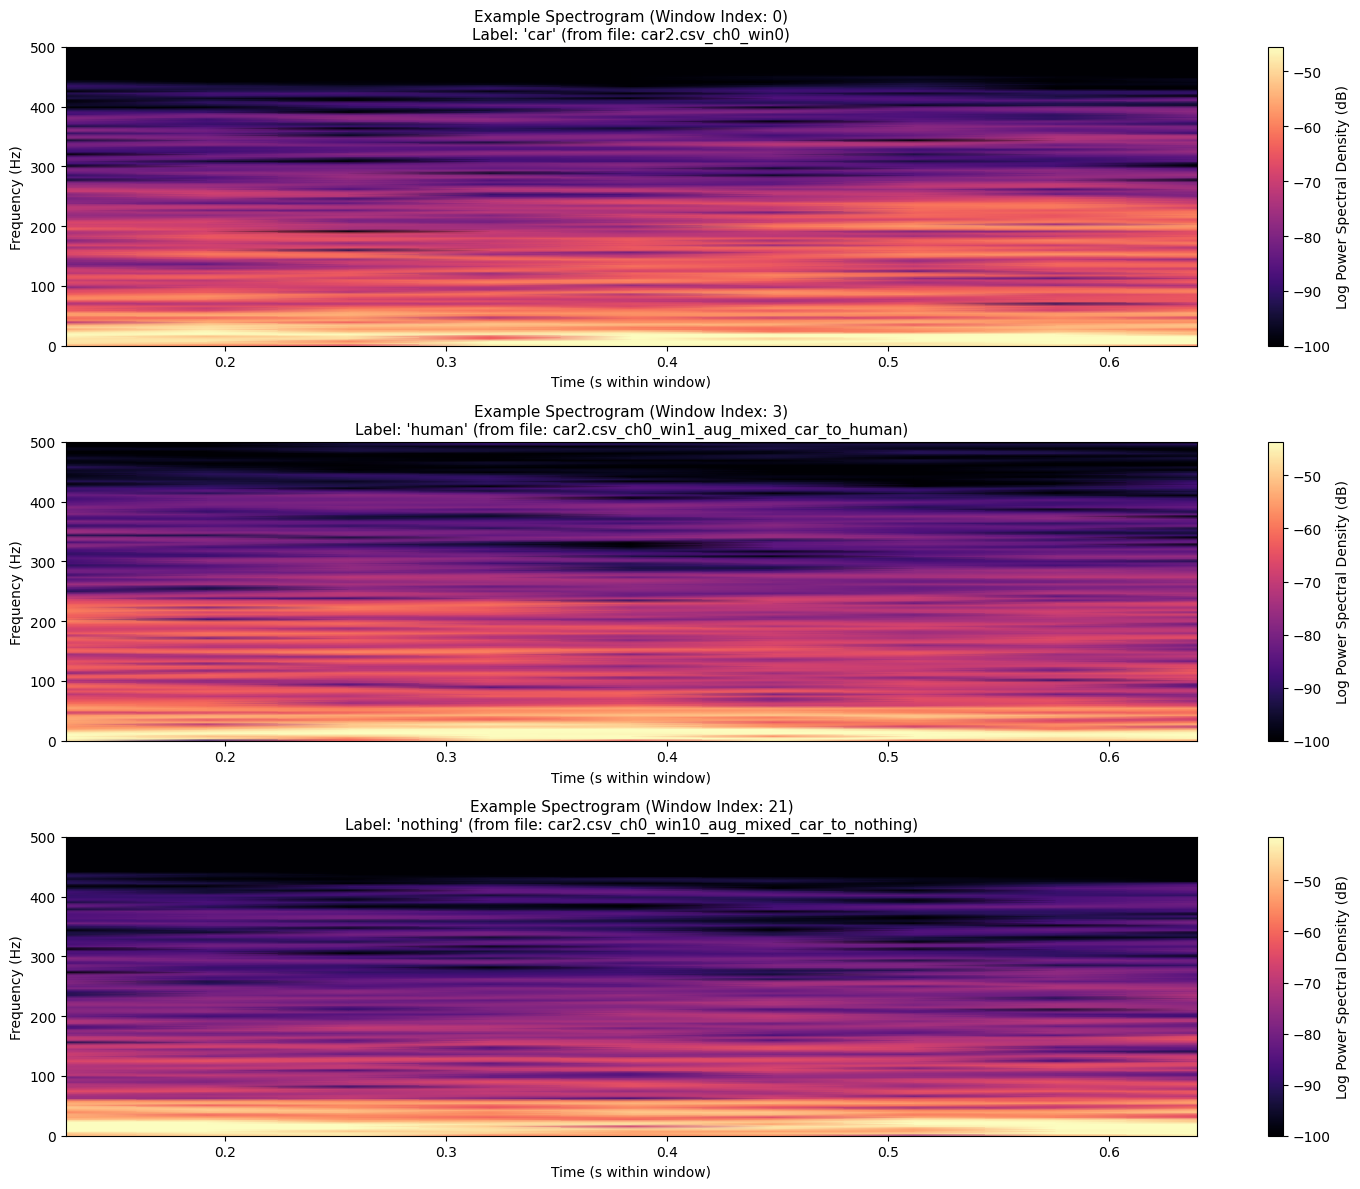

In [99]:
# =============================================================================
# --- 6. יצירת ספקטרוגרמות (Generating Spectrograms) ---
# =============================================================================
print("\n--- 6. Generating Spectrograms from Windows ---")

# Ensure all_windows exists from the previous step
if 'all_windows' not in locals() or not all_windows:
    print("Error: 'all_windows' list not found or is empty. Cannot generate spectrograms.")
    exit()
if 'all_window_labels' not in locals() or len(all_windows) != len(all_window_labels):
     print("Error: Mismatch between 'all_windows' and 'all_window_labels'. Cannot proceed.")
     exit()


all_spectrograms = []        # List to store the generated spectrograms (as numpy arrays)
all_spec_labels = []         # List to store labels corresponding to successfully generated spectrograms
successful_indices = []      # Keep track of indices where spectrogram generation succeeded

spectrogram_pbar = tqdm(enumerate(all_windows), total=len(all_windows), desc="Generating Spectrograms", leave=False)

for i, window_signal in spectrogram_pbar:
    try:
        # Calculate Spectrogram using scipy.signal
        frequencies, times, Sxx = sp_signal.spectrogram(
            window_signal,
            fs=SAMPLING_RATE,
            window=WINDOW,
            nperseg=NPERSEG,
            noverlap=NOVERLAP,
            scaling=SCALING,
            mode=MODE,
            axis=0 # Ensure calculation along the time axis (default anyway)
        )

        # Convert to dB scale (Logarithmic scale)
        # Use np.maximum to handle potential zero or near-zero values before log10
        log_Sxx = 10 * np.log10(np.maximum(Sxx, EPSILON))

        # Ensure the result is float32 for PyTorch efficiency
        log_Sxx = log_Sxx.astype(np.float32)

        # Check for NaN or Inf values after calculation (can happen with extreme inputs)
        if not np.all(np.isfinite(log_Sxx)):
             tqdm.write(f"Warning: Non-finite values (NaN/Inf) found in spectrogram for window index {i}. Skipping.")
             continue

        all_spectrograms.append(log_Sxx)
        all_spec_labels.append(all_window_labels[i]) # Keep the original label
        successful_indices.append(i) # Record the index of the successful window

    except ValueError as ve:
        # This might happen if window_signal is shorter than nperseg after potential issues
        tqdm.write(f"Skipping spectrogram for window index {i} due to ValueError: {ve}. "
                   f"Window length={len(window_signal)}, nperseg={NPERSEG}")
    except Exception as e:
        # Catch other potential errors during spectrogram calculation
        tqdm.write(f"Error generating spectrogram for window index {i}: {type(e).__name__} - {e}")


print(f"\nGenerated {len(all_spectrograms)} spectrograms successfully (out of {len(all_windows)} windows).")
if not all_spectrograms:
    print("Error: No spectrograms were generated successfully. Check windowing results or spectrogram parameters.")
    exit()

# --- Optional: Plot examples of spectrograms ---
num_spec_examples = 3
print(f"\nPlotting examples of generated spectrograms (up to {num_spec_examples})...")

# Find example indices for different labels if possible
example_indices_to_plot = []
labels_plotted = set()
indices_tried = set()
available_labels_in_specs = sorted(list(set(all_spec_labels)))

# Try to get one example per label first
for target_label in available_labels_in_specs:
     if len(example_indices_to_plot) >= num_spec_examples: break
     found = False
     # Find the first index corresponding to this label among successful spectrograms
     for idx, spec_label in enumerate(all_spec_labels):
         if spec_label == target_label and idx not in indices_tried:
              example_indices_to_plot.append(idx)
              indices_tried.add(idx)
              labels_plotted.add(target_label)
              found = True
              break
     # if not found:
          # print(f"Could not find a spectrogram example for label '{target_label}'.")


# Fill remaining slots if needed, avoiding duplicates
while len(example_indices_to_plot) < num_spec_examples and len(indices_tried) < len(all_spectrograms):
     idx_to_try = random.choice([i for i in range(len(all_spectrograms)) if i not in indices_tried])
     example_indices_to_plot.append(idx_to_try)
     indices_tried.add(idx_to_try)


if example_indices_to_plot:
    # Determine frequency and time axes from the last generated spectrogram (assuming they are consistent)
    # Need to recalculate F and T based on the *first* successful example
    first_successful_original_index = successful_indices[0]
    first_window = all_windows[first_successful_original_index]
    try:
        frequencies_ex, times_ex, _ = sp_signal.spectrogram(first_window, fs=SAMPLING_RATE, window=WINDOW, nperseg=NPERSEG, noverlap=NOVERLAP, scaling=SCALING, mode=MODE)
        freq_max_plot = SAMPLING_RATE / 2 # Nyquist frequency
        freq_indices_plot = np.where(frequencies_ex <= freq_max_plot)[0]
        freq_ticks = frequencies_ex[freq_indices_plot]
        time_ticks = times_ex # Time relative to the start of the window
        # הדפס את ערכי times_ex כדי לבדוק את ציר הזמן
        print(f"times_ex: {times_ex}")
        print(f"Window length: {len(first_window)}, Expected: {WINDOW_SIZE_SAMPLES}")
        print(f"times_ex range: {times_ex[0]} to {times_ex[-1]} (should be close to 0.5)")
    except Exception as e:
        print(f"Warning: Could not calculate axes for example plot due to: {e}. Using generic axes.")
        frequencies_ex, times_ex = None, None


    plt.figure(figsize=(15, num_spec_examples * 4))
    for plot_i, spec_idx in enumerate(example_indices_to_plot):
        spectrogram_to_plot = all_spectrograms[spec_idx]
        label_to_plot = all_spec_labels[spec_idx]
        original_window_idx = successful_indices[spec_idx] # Get original index if needed
        original_filename = all_window_origins[original_window_idx] if 'all_window_origins' in locals() else 'Unknown'

        plt.subplot(num_spec_examples, 1, plot_i + 1)

        # Choose appropriate vmin/vmax for visualization (might need tuning)
        vmin = np.percentile(spectrogram_to_plot, 5)  # Adjust percentiles as needed
        vmax = np.percentile(spectrogram_to_plot, 98)

        # Use pcolormesh for correct axis mapping
        if frequencies_ex is not None and times_ex is not None:
             # Plot only up to Nyquist frequency
             img = plt.pcolormesh(times_ex, freq_ticks, spectrogram_to_plot[freq_indices_plot, :],
                                  shading='gouraud', cmap='magma', vmin=vmin, vmax=vmax) # 'gouraud' for smoother look
        else:
             # Fallback if axes calculation failed
             img = plt.imshow(spectrogram_to_plot, aspect='auto', origin='lower',
                              cmap='magma', vmin=vmin, vmax=vmax)


        plt.colorbar(img, label='Log Power Spectral Density (dB)')
        plt.ylabel('Frequency (Hz)', fontsize=10)
        plt.xlabel('Time (s within window)', fontsize=10)
        plt.title(f"Example Spectrogram (Window Index: {original_window_idx})\nLabel: '{label_to_plot}' (from file: {original_filename})", fontsize=11)

    plt.tight_layout()
    # Save the combined plot
    spec_example_filename = os.path.join(PLOT_SAVE_DIR, "EXAMPLE_Spectrograms.png")
    try:
        plt.savefig(spec_example_filename)
        print(f"Example spectrogram plot saved to: {spec_example_filename}")
    except Exception as e:
        print(f"Error saving spectrogram example plot: {e}")
        plt.show()

else:
    print("No spectrogram examples to plot.")


print("-" * 30)

In [100]:
# =============================================================================
# --- 7. הכנת נתונים לאימון (Data Preparation for Training) ---
# =============================================================================
print("\n--- 7. Preparing Data for Training ---")

# Ensure spectrograms and labels exist from the previous step
if 'all_spectrograms' not in locals() or not all_spectrograms:
    print("Error: 'all_spectrograms' list not found or is empty. Cannot prepare data.")
    exit()
if 'all_spec_labels' not in locals() or len(all_spectrograms) != len(all_spec_labels):
     print("Error: Mismatch between 'all_spectrograms' and 'all_spec_labels'. Cannot proceed.")
     exit()

# 1. Encode Labels
print("Encoding labels...")
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_spec_labels)
num_classes = len(label_encoder.classes_)
class_names = list(label_encoder.classes_)
print(f"Label encoding: {list(zip(class_names, range(num_classes)))}\n")

# 2. Add Channel Dimension for CNN
print("Adding channel dimension to spectrograms...")
# Convert list of numpy arrays to a single numpy array first
spectrograms_array = np.array(all_spectrograms)
# Add the channel dimension (axis=1 for PyTorch Conv2d: Batch, Channel, Height, Width)
spectrograms_with_channel = spectrograms_array[:, np.newaxis, :, :]
print(f"Spectrogram array shape: {spectrograms_with_channel.shape}") # (num_windows, 1, freq_bins, time_bins)
if len(spectrograms_with_channel.shape) != 4:
    print("Error: Spectrogram array does not have 4 dimensions (Batch, Channel, Height, Width). Check conversion.")
    exit()


# 3. Split Data into Train, Validation, Test sets
print("Splitting data into Train, Validation, and Test sets...")
X = spectrograms_with_channel
y = encoded_labels

# Check if enough samples exist for splitting
min_samples_per_class_for_split = 2 # Need at least 2 per class for stratification in both splits
y_counts = np.bincount(y)
if len(y) < 10 or np.any(y_counts < min_samples_per_class_for_split * 2 ): # Need enough for test split and then val split
    print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("Warning: Very few samples or samples per class available.")
    print(f"Total samples: {len(y)}, Samples per class: {y_counts}")
    print("Stratified splitting might fail or be unreliable.")
    print("Consider reducing TEST_SIZE/VALIDATION_SIZE or getting more data.")
    print("Attempting split anyway, but monitor results carefully.")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
    # If stratification fails later, the code includes a fallback to non-stratified split.

# Split into Train+Val and Test
try:
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=SEED,
        stratify=y # Try to maintain class proportions
    )
except ValueError as e:
     print(f"Warning: Stratified Train/Test split failed: {e}. Falling back to non-stratified split.")
     X_train_val, X_test, y_train_val, y_test = train_test_split(
         X, y, test_size=TEST_SIZE, random_state=SEED
     )

# Split Train+Val into Train and Validation
if len(X_train_val) > 0:
    # Calculate the validation proportion relative to the train_val set size
    val_size_adjusted = VALIDATION_SIZE / (1.0 - TEST_SIZE)
    if val_size_adjusted >= 1.0 or val_size_adjusted <= 0.0:
         print(f"Warning: Invalid adjusted validation size ({val_size_adjusted:.2f}). Using 15% of train_val if possible.")
         val_size_adjusted = 0.15 # Fallback to a fixed percentage

    try:
        # Ensure there are enough samples in train_val for the split
        if len(X_train_val) < 2 or (val_size_adjusted > 0 and int(len(X_train_val) * val_size_adjusted) < 1):
             print("Warning: Not enough samples in train_val set to create a validation set. Using Test set as Val set.")
             X_train, X_val, y_train, y_val = X_train_val, X_test, y_train_val, y_test # Use test set as validation (not ideal!)
        else:
             # Try stratified split first
             y_tv_counts = np.bincount(y_train_val)
             if np.any(y_tv_counts < min_samples_per_class_for_split):
                  print("Warning: Not enough samples per class in train_val for stratified split. Falling back to non-stratified.")
                  X_train, X_val, y_train, y_val = train_test_split(
                      X_train_val, y_train_val, test_size=val_size_adjusted, random_state=SEED
                  )
             else:
                  X_train, X_val, y_train, y_val = train_test_split(
                      X_train_val, y_train_val,
                      test_size=val_size_adjusted,
                      random_state=SEED,
                      stratify=y_train_val # Try to stratify
                  )
    except ValueError as e:
         print(f"Warning: Stratified Train/Val split failed: {e}. Falling back to non-stratified split.")
         X_train, X_val, y_train, y_val = train_test_split(
             X_train_val, y_train_val, test_size=val_size_adjusted, random_state=SEED
         )
else:
    # Handle case where train_val set is empty (shouldn't happen if initial data exists)
    print("Error: Train+Val set is empty after initial split. Cannot proceed.")
    X_train, X_val, y_train, y_val = np.array([]), np.array([]), np.array([]), np.array([]) # Assign empty arrays
    exit()


print(f"\nData split results:")
print(f"- Training set:   {len(X_train)} samples")
print(f"- Validation set: {len(X_val)} samples")
print(f"- Test set:       {len(X_test)} samples")

# Check if any set is empty
if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
     print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
     print("Error: One or more data splits (Train, Val, Test) are empty.")
     print("This likely happened due to very few initial windows or issues during splitting.")
     print("Cannot proceed with training.")
     print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
     exit()

print("\nClass distribution in splits:")
for name, labels in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    counts = np.bincount(labels, minlength=num_classes)
    dist_str = ", ".join([f"{cname}:{c}" for cname, c in zip(class_names, counts)])
    print(f"- {name}: {dist_str}")


# 4. Create PyTorch Datasets with Augmentation
print("\nCreating PyTorch Datasets...")

class SpectrogramDataset(Dataset):
    def __init__(self, features, labels, apply_augmentation=False, aug_prob=0.0, spec_aug_params=None):
        # Convert numpy arrays to torch tensors immediately
        self.features = torch.from_numpy(features).float() # Spectrograms
        self.labels = torch.from_numpy(labels).long()   # Encoded labels
        self.apply_augmentation = apply_augmentation
        self.aug_prob = aug_prob
        self.spec_aug_params = spec_aug_params if spec_aug_params else {}

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        spec = self.features[idx] # Get the tensor (already float32)
        label = self.labels[idx]  # Get the tensor (already long)

        # Apply augmentation only if specified (for training set) and with a certain probability
        if self.apply_augmentation and random.random() < self.aug_prob:
            # Ensure spec has channel dimension removed for spec_augment function
            # Our spec_augment function expects (Freq, Time)
            spec_no_channel = spec.squeeze(0) # Remove channel dim (assuming it's size 1)

            augmented_spec = spec_augment(
                spec_no_channel,
                freq_mask_param=self.spec_aug_params.get('freq_mask_param', 0),
                time_mask_param=self.spec_aug_params.get('time_mask_param', 0),
                num_freq_masks=self.spec_aug_params.get('num_freq_masks', 0),
                num_time_masks=self.spec_aug_params.get('num_time_masks', 0)
            )
            # Add channel dimension back
            spec = augmented_spec.unsqueeze(0)

        return spec, label

# Instantiate Datasets
# IMPORTANT: Apply augmentation ONLY to the training set
train_dataset = SpectrogramDataset(X_train, y_train,
                                   apply_augmentation=True,
                                   aug_prob=AUGMENTATION_PROB,
                                   spec_aug_params=SPECAUGMENT_PARAMS)
val_dataset = SpectrogramDataset(X_val, y_val, apply_augmentation=False) # No augmentation for validation
test_dataset = SpectrogramDataset(X_test, y_test, apply_augmentation=False) # No augmentation for test

print("SpectrogramDataset class defined with augmentation logic.")


# 5. Create DataLoaders
print("\nCreating PyTorch DataLoaders...")
# Determine appropriate number of workers
num_workers = 0 # Start with 0 for compatibility/debugging, increase later if needed
#if os.cpu_count() and os.cpu_count() > 1:
#    num_workers = min(os.cpu_count(), 4) # Use up to 4 workers or CPU count, whichever is smaller

print(f"Using num_workers={num_workers} for DataLoaders.")

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True, # Shuffle training data each epoch
                          num_workers=num_workers,
                          pin_memory=True if torch.cuda.is_available() else False, # Pin memory if using GPU
                          drop_last=False) # Keep last batch even if smaller

val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE * 2, # Often use larger batch size for validation/test
                        shuffle=False, # No need to shuffle validation data
                        num_workers=num_workers,
                        pin_memory=True if torch.cuda.is_available() else False,
                        drop_last=False)

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE * 2, # Often use larger batch size for validation/test
                         shuffle=False, # No need to shuffle test data
                         num_workers=num_workers,
                         pin_memory=True if torch.cuda.is_available() else False,
                         drop_last=False)

print("PyTorch DataLoaders created.")
print("-" * 30)


--- 7. Preparing Data for Training ---
Encoding labels...
Label encoding: [(np.str_('car'), 0), (np.str_('human'), 1), (np.str_('nothing'), 2)]

Adding channel dimension to spectrograms...
Spectrogram array shape: (15417, 1, 129, 9)
Splitting data into Train, Validation, and Test sets...

Data split results:
- Training set:   10791 samples
- Validation set: 2313 samples
- Test set:       2313 samples

Class distribution in splits:
- Train: car:2349, human:4163, nothing:4279
- Val: car:504, human:892, nothing:917
- Test: car:504, human:892, nothing:917

Creating PyTorch Datasets...
SpectrogramDataset class defined with augmentation logic.

Creating PyTorch DataLoaders...
Using num_workers=0 for DataLoaders.
PyTorch DataLoaders created.
------------------------------


In [101]:
# =============================================================================
# --- 8. הגדרת מודל CNN (CNN Model Definition) ---
# =============================================================================
print("\n--- 8. Defining Enhanced CNN Model with Improved Architecture ---")

# Ensure necessary variables exist from previous steps
if 'num_classes' not in locals():
     print("Error: 'num_classes' not defined. Please run the data preparation step (Step 7) first.")
     exit()
if 'spectrograms_with_channel' not in locals() or spectrograms_with_channel.ndim != 4:
     print("Error: Spectrogram data ('spectrograms_with_channel') not found or has incorrect dimensions.")
     exit()

# Get spectrogram dimensions from the prepared data array
spec_height = spectrograms_with_channel.shape[2] # Frequency bins
spec_width = spectrograms_with_channel.shape[3]  # Time frames/bins
print(f"Input spectrogram dimensions for model: Height={spec_height}, Width={spec_width}")


class EnhancedCNN(nn.Module):
    def __init__(self, num_classes, input_height, input_width, dropout_rate=0.3):
        super(EnhancedCNN, self).__init__()
        self.dropout_rate = dropout_rate

        # --- Convolutional Blocks ---
        # Block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)



        # --- Spatial Attention Mechanism --- <<<--- Moved here, before dynamic calculation
        self.attention = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1), # Input channels match output of conv3
            nn.Sigmoid()
        )

        # --- Dynamically Calculate Flattened Size ---
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, input_height, input_width)
            dummy_output = self._forward_conv_features(dummy_input) # This call now works
            self.flattened_size = int(np.prod(dummy_output.shape[1:]))

        print(f"Dynamically calculated flattened feature size: {self.flattened_size}")
        if self.flattened_size == 0:
             raise ValueError("Calculated flattened size is zero. CNN architecture might be reducing dimensions too much.")

        # --- Fully Connected Layers ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.relu_fc1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=self.dropout_rate)
        self.fc2 = nn.Linear(256, 128)
        self.relu_fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=self.dropout_rate)
        self.fc3 = nn.Linear(128, num_classes)

    def _forward_conv_features(self, x):
        """Forward pass through convolutional blocks with spatial attention"""
        # Block 1
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        
        # Block 2
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        
        # Block 3 with attention
        attention_mask = self.attention(x)
        x = x * attention_mask

        return x

    def forward(self, x):
        x = self._forward_conv_features(x)
        x = self.flatten(x)
        x = self.relu_fc1(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x) 
        return x

# --- Instantiate the Enhanced Model ---
model = EnhancedCNN(num_classes=num_classes,
                    input_height=spec_height,
                    input_width=spec_width,
                    dropout_rate=DROPOUT_RATE)

# --- Move Model to Device (GPU or CPU) ---
if 'device' not in locals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device was not defined, setting to: {device}")

model.to(device)
print(f"\nEnhanced CNN model with spatial attention defined and moved to '{device}'.")

# --- Optional: Print Model Summary ---
try:
    from torchsummary import summary # Requires torchsummary package: pip install torchsummary
    print("\nModel Summary:")
    summary(model, input_size=(1, spec_height, spec_width))
except ImportError:
    print("\n(Install 'torchsummary' with 'pip install torchsummary' to see the model summary)")
except Exception as e:
    print(f"Could not print model summary: {e}")


print("-" * 30)


--- 8. Defining Enhanced CNN Model with Improved Architecture ---
Input spectrogram dimensions for model: Height=129, Width=9
Dynamically calculated flattened feature size: 4096

Enhanced CNN model with spatial attention defined and moved to 'cuda'.

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 129, 9]             320
       BatchNorm2d-2           [-1, 32, 129, 9]              64
              ReLU-3           [-1, 32, 129, 9]               0
         MaxPool2d-4            [-1, 32, 64, 4]               0
            Conv2d-5            [-1, 64, 64, 4]          18,496
       BatchNorm2d-6            [-1, 64, 64, 4]             128
              ReLU-7            [-1, 64, 64, 4]               0
         MaxPool2d-8            [-1, 64, 32, 2]               0
            Conv2d-9             [-1, 1, 32, 2]              65
          Sigmoid-10        

In [102]:
# =============================================================================
# --- 9. הגדרת אימון (Training Setup) ---
# =============================================================================
print("\n--- 9. Setting up Training ---")

# Ensure the model object exists from the previous step
if 'model' not in locals() or not isinstance(model, nn.Module):
    print("Error: 'model' object not found or is not a valid nn.Module. Please run Step 8 first.")
    exit()
# Ensure device is defined
if 'device' not in locals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Warning: 'device' was not defined, setting to: {device}")

# 1. Loss Function
# CrossEntropyLoss is suitable for multi-class classification problems.
# It combines LogSoftmax and NLLLoss in one single class.
criterion = nn.CrossEntropyLoss()
print(f"Loss Function: {type(criterion).__name__}")

# 2. Optimizer
# Using AdamW with improved settings and proper weight decay handling
optimizer = optim.AdamW(model.parameters(),
                        lr=LEARNING_RATE,
                        weight_decay=WEIGHT_DECAY,
                        amsgrad=True)  # Enable AmsGrad for better convergence
print(f"Optimizer: {type(optimizer).__name__} (Initial LR={LEARNING_RATE}, WeightDecay={WEIGHT_DECAY}, AmsGrad=True)")

# 3. Learning Rate Scheduler
# ReduceLROnPlateau reduces LR when metric stops improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Monitor loss (lower = better)
    factor=0.2,           # Multiply LR by this factor when reducing
    patience=15,          # Number of epochs with no improvement after which LR will be reduced
    verbose=True,         # Print message when LR is reduced
    min_lr=1e-6,          # Lower bound on the learning rate
    threshold=0.0001,     # Minimum significant change
    threshold_mode='rel'  # Interpret threshold as relative change
)
print(f"LR Scheduler: {type(scheduler).__name__} (Factor=0.2, Patience=15, MinLR=1e-6)")

# --- Sanity Check: Ensure model parameters require gradients ---
params_requiring_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel Parameters: Total={total_params:,}, Trainable={params_requiring_grad:,}")
if params_requiring_grad == 0:
    print("Error: No trainable parameters found in the model!")
    exit()

print("-" * 30)


--- 9. Setting up Training ---
Loss Function: CrossEntropyLoss
Optimizer: AdamW (Initial LR=1e-05, WeightDecay=0.005, AmsGrad=True)
LR Scheduler: ReduceLROnPlateau (Factor=0.2, Patience=15, MinLR=1e-6)

Model Parameters: Total=1,101,188, Trainable=1,101,188
------------------------------


C:\Users\lidor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



--- 10. Starting Training ---
Training for a maximum of 100 epochs with early stopping patience of 40.
Best model will be saved to 'best_cnn_model_enhanced.pth'.



Epoch 1/100 [1.3s] - LR: 1.0e-05 - Train Loss: 3.8604, Acc: 37.95% - Val Loss: 3.0934, Acc: 41.81% -> Val Acc Improved! (0.00% -> 41.81%). Saving model...


Epoch 2/100 [1.1s] - LR: 1.0e-05 - Train Loss: 1.8432, Acc: 48.65% - Val Loss: 1.3207, Acc: 54.69% -> Val Acc Improved! (41.81% -> 54.69%). Saving model...


Epoch 3/100 [1.0s] - LR: 1.0e-05 - Train Loss: 1.1180, Acc: 53.66% - Val Loss: 0.9306, Acc: 61.78% -> Val Acc Improved! (54.69% -> 61.78%). Saving model...


Epoch 4/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.9650, Acc: 58.24% - Val Loss: 0.8208, Acc: 67.01% -> Val Acc Improved! (61.78% -> 67.01%). Saving model...


Epoch 5/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.8908, Acc: 62.19% - Val Loss: 0.7496, Acc: 74.32% -> Val Acc Improved! (67.01% -> 74.32%). Saving model...


Epoch 6/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.8400, Acc: 65.21% - Val Loss: 0.6984, Acc: 77.17% -> Val Acc Improved! (74.32% -> 77.17%). Saving model...


Epoch 7/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.7883, Acc: 67.83% - Val Loss: 0.6552, Acc: 79.25% -> Val Acc Improved! (77.17% -> 79.25%). Saving model...


Epoch 8/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.7516, Acc: 70.35% - Val Loss: 0.6215, Acc: 79.94% -> Val Acc Improved! (79.25% -> 79.94%). Saving model...


Epoch 9/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.7107, Acc: 72.81% - Val Loss: 0.5921, Acc: 81.41% -> Val Acc Improved! (79.94% -> 81.41%). Saving model...


Epoch 10/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.6808, Acc: 74.44% - Val Loss: 0.5664, Acc: 81.63% -> Val Acc Improved! (81.41% -> 81.63%). Saving model...


Epoch 11/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.6582, Acc: 75.83% - Val Loss: 0.5464, Acc: 82.92% -> Val Acc Improved! (81.63% -> 82.92%). Saving model...


Epoch 12/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.6421, Acc: 76.80% - Val Loss: 0.5318, Acc: 83.18% -> Val Acc Improved! (82.92% -> 83.18%). Saving model...


Epoch 13/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.6192, Acc: 77.55% - Val Loss: 0.5175, Acc: 83.70% -> Val Acc Improved! (83.18% -> 83.70%). Saving model...


Epoch 14/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.6052, Acc: 78.58% - Val Loss: 0.5056, Acc: 84.00% -> Val Acc Improved! (83.70% -> 84.00%). Saving model...


Epoch 15/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.5955, Acc: 79.24% - Val Loss: 0.4968, Acc: 84.31% -> Val Acc Improved! (84.00% -> 84.31%). Saving model...


Epoch 16/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.5858, Acc: 79.09% - Val Loss: 0.4893, Acc: 85.26% -> Val Acc Improved! (84.31% -> 85.26%). Saving model...


Epoch 17/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.5735, Acc: 79.92% - Val Loss: 0.4821, Acc: 85.47% -> Val Acc Improved! (85.26% -> 85.47%). Saving model...


Epoch 18/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.5595, Acc: 81.06% - Val Loss: 0.4744, Acc: 85.78% -> Val Acc Improved! (85.47% -> 85.78%). Saving model...


Epoch 19/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.5548, Acc: 81.24% - Val Loss: 0.4672, Acc: 85.86% -> Val Acc Improved! (85.78% -> 85.86%). Saving model...


Epoch 20/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.5504, Acc: 81.51% - Val Loss: 0.4633, Acc: 86.34% -> Val Acc Improved! (85.86% -> 86.34%). Saving model...


Epoch 21/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.5408, Acc: 81.86% - Val Loss: 0.4565, Acc: 86.38% -> Val Acc Improved! (86.34% -> 86.38%). Saving model...


Epoch 22/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.5357, Acc: 81.76% - Val Loss: 0.4519, Acc: 86.42% -> Val Acc Improved! (86.38% -> 86.42%). Saving model...


Epoch 23/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.5306, Acc: 82.76% - Val Loss: 0.4476, Acc: 86.68% -> Val Acc Improved! (86.42% -> 86.68%). Saving model...


Epoch 24/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.5268, Acc: 82.96% - Val Loss: 0.4428, Acc: 86.86% -> Val Acc Improved! (86.68% -> 86.86%). Saving model...


Epoch 25/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.5176, Acc: 83.07% - Val Loss: 0.4400, Acc: 87.29% -> Val Acc Improved! (86.86% -> 87.29%). Saving model...


Epoch 26/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.5104, Acc: 83.30% - Val Loss: 0.4349, Acc: 87.25% -> Val Acc No Improve (1/40). Best: 87.29%


Epoch 27/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.5134, Acc: 83.57% - Val Loss: 0.4333, Acc: 87.12% -> Val Acc No Improve (2/40). Best: 87.29%


Epoch 28/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.5050, Acc: 83.65% - Val Loss: 0.4299, Acc: 87.42% -> Val Acc Improved! (87.29% -> 87.42%). Saving model...


Epoch 29/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.5046, Acc: 83.69% - Val Loss: 0.4263, Acc: 87.64% -> Val Acc Improved! (87.42% -> 87.64%). Saving model...


Epoch 30/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.4979, Acc: 84.24% - Val Loss: 0.4235, Acc: 87.76% -> Val Acc Improved! (87.64% -> 87.76%). Saving model...


Epoch 31/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.4951, Acc: 84.31% - Val Loss: 0.4216, Acc: 87.72% -> Val Acc No Improve (1/40). Best: 87.76%


Epoch 32/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.4916, Acc: 84.41% - Val Loss: 0.4186, Acc: 87.72% -> Val Acc No Improve (2/40). Best: 87.76%


Epoch 33/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.4846, Acc: 84.67% - Val Loss: 0.4163, Acc: 87.98% -> Val Acc Improved! (87.76% -> 87.98%). Saving model...


Epoch 34/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.4889, Acc: 84.96% - Val Loss: 0.4130, Acc: 88.11% -> Val Acc Improved! (87.98% -> 88.11%). Saving model...


Epoch 35/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.4757, Acc: 84.90% - Val Loss: 0.4117, Acc: 88.24% -> Val Acc Improved! (88.11% -> 88.24%). Saving model...


Epoch 36/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.4834, Acc: 85.07% - Val Loss: 0.4101, Acc: 88.20% -> Val Acc No Improve (1/40). Best: 88.24%


Epoch 37/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.4759, Acc: 85.02% - Val Loss: 0.4105, Acc: 88.07% -> Val Acc No Improve (2/40). Best: 88.24%


Epoch 38/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.4701, Acc: 85.39% - Val Loss: 0.4067, Acc: 88.37% -> Val Acc Improved! (88.24% -> 88.37%). Saving model...


Epoch 39/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.4708, Acc: 85.65% - Val Loss: 0.4051, Acc: 88.37% -> Val Acc No Improve (1/40). Best: 88.37%


Epoch 40/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.4694, Acc: 85.50% - Val Loss: 0.4056, Acc: 88.37% -> Val Acc No Improve (2/40). Best: 88.37%


Epoch 41/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.4684, Acc: 85.60% - Val Loss: 0.4029, Acc: 88.54% -> Val Acc Improved! (88.37% -> 88.54%). Saving model...


Epoch 42/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.4644, Acc: 85.63% - Val Loss: 0.3999, Acc: 88.76% -> Val Acc Improved! (88.54% -> 88.76%). Saving model...


Epoch 43/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.4627, Acc: 86.08% - Val Loss: 0.3996, Acc: 88.85% -> Val Acc Improved! (88.76% -> 88.85%). Saving model...


Epoch 44/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.4606, Acc: 85.83% - Val Loss: 0.3993, Acc: 88.85% -> Val Acc No Improve (1/40). Best: 88.85%


Epoch 45/100 [1.2s] - LR: 1.0e-05 - Train Loss: 0.4583, Acc: 86.09% - Val Loss: 0.3964, Acc: 89.02% -> Val Acc Improved! (88.85% -> 89.02%). Saving model...


Epoch 46/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4560, Acc: 86.27% - Val Loss: 0.3965, Acc: 88.50% -> Val Acc No Improve (1/40). Best: 89.02%


Epoch 47/100 [1.4s] - LR: 1.0e-05 - Train Loss: 0.4578, Acc: 86.18% - Val Loss: 0.3946, Acc: 89.02% -> Val Acc No Improve (2/40). Best: 89.02%


Epoch 48/100 [1.2s] - LR: 1.0e-05 - Train Loss: 0.4539, Acc: 86.23% - Val Loss: 0.3942, Acc: 89.06% -> Val Acc Improved! (89.02% -> 89.06%). Saving model...


Epoch 49/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4560, Acc: 86.15% - Val Loss: 0.3917, Acc: 89.06% -> Val Acc No Improve (1/40). Best: 89.06%


Epoch 50/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4467, Acc: 86.50% - Val Loss: 0.3914, Acc: 89.11% -> Val Acc Improved! (89.06% -> 89.11%). Saving model...


Epoch 51/100 [1.2s] - LR: 1.0e-05 - Train Loss: 0.4500, Acc: 86.46% - Val Loss: 0.3905, Acc: 88.89% -> Val Acc No Improve (1/40). Best: 89.11%


Epoch 52/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4431, Acc: 86.88% - Val Loss: 0.3898, Acc: 89.32% -> Val Acc Improved! (89.11% -> 89.32%). Saving model...


Epoch 53/100 [1.2s] - LR: 1.0e-05 - Train Loss: 0.4483, Acc: 86.47% - Val Loss: 0.3893, Acc: 89.28% -> Val Acc No Improve (1/40). Best: 89.32%


Epoch 54/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4450, Acc: 86.66% - Val Loss: 0.3878, Acc: 89.23% -> Val Acc No Improve (2/40). Best: 89.32%


Epoch 55/100 [1.2s] - LR: 1.0e-05 - Train Loss: 0.4428, Acc: 86.63% - Val Loss: 0.3877, Acc: 89.02% -> Val Acc No Improve (3/40). Best: 89.32%


Epoch 56/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4410, Acc: 86.77% - Val Loss: 0.3860, Acc: 89.15% -> Val Acc No Improve (4/40). Best: 89.32%


Epoch 57/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4388, Acc: 86.86% - Val Loss: 0.3849, Acc: 89.15% -> Val Acc No Improve (5/40). Best: 89.32%


Epoch 58/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4358, Acc: 87.17% - Val Loss: 0.3843, Acc: 89.15% -> Val Acc No Improve (6/40). Best: 89.32%


Epoch 59/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4401, Acc: 86.74% - Val Loss: 0.3832, Acc: 89.32% -> Val Acc No Improve (7/40). Best: 89.32%


Epoch 60/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4372, Acc: 87.02% - Val Loss: 0.3817, Acc: 89.32% -> Val Acc No Improve (8/40). Best: 89.32%


Epoch 61/100 [1.4s] - LR: 1.0e-05 - Train Loss: 0.4363, Acc: 86.89% - Val Loss: 0.3813, Acc: 89.41% -> Val Acc Improved! (89.32% -> 89.41%). Saving model...


Epoch 62/100 [1.4s] - LR: 1.0e-05 - Train Loss: 0.4331, Acc: 87.22% - Val Loss: 0.3815, Acc: 89.41% -> Val Acc No Improve (1/40). Best: 89.41%


Epoch 63/100 [1.4s] - LR: 1.0e-05 - Train Loss: 0.4292, Acc: 87.47% - Val Loss: 0.3804, Acc: 89.32% -> Val Acc No Improve (2/40). Best: 89.41%


Epoch 64/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4309, Acc: 87.28% - Val Loss: 0.3792, Acc: 89.41% -> Val Acc No Improve (3/40). Best: 89.41%


Epoch 65/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4255, Acc: 87.46% - Val Loss: 0.3789, Acc: 89.28% -> Val Acc No Improve (4/40). Best: 89.41%


Epoch 66/100 [1.2s] - LR: 1.0e-05 - Train Loss: 0.4244, Acc: 87.50% - Val Loss: 0.3777, Acc: 89.49% -> Val Acc Improved! (89.41% -> 89.49%). Saving model...


Epoch 67/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.4289, Acc: 87.38% - Val Loss: 0.3778, Acc: 89.54% -> Val Acc Improved! (89.49% -> 89.54%). Saving model...


Epoch 68/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.4257, Acc: 87.46% - Val Loss: 0.3784, Acc: 89.28% -> Val Acc No Improve (1/40). Best: 89.54%


Epoch 69/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.4240, Acc: 87.19% - Val Loss: 0.3771, Acc: 89.28% -> Val Acc No Improve (2/40). Best: 89.54%


Epoch 70/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.4167, Acc: 88.06% - Val Loss: 0.3763, Acc: 89.45% -> Val Acc No Improve (3/40). Best: 89.54%


Epoch 71/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.4188, Acc: 87.60% - Val Loss: 0.3747, Acc: 89.19% -> Val Acc No Improve (4/40). Best: 89.54%


Epoch 72/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.4175, Acc: 87.61% - Val Loss: 0.3744, Acc: 89.41% -> Val Acc No Improve (5/40). Best: 89.54%


Epoch 73/100 [1.0s] - LR: 1.0e-05 - Train Loss: 0.4202, Acc: 87.60% - Val Loss: 0.3740, Acc: 89.58% -> Val Acc Improved! (89.54% -> 89.58%). Saving model...


Epoch 74/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.4254, Acc: 87.67% - Val Loss: 0.3732, Acc: 89.54% -> Val Acc No Improve (1/40). Best: 89.58%


Epoch 75/100 [1.2s] - LR: 1.0e-05 - Train Loss: 0.4183, Acc: 87.90% - Val Loss: 0.3732, Acc: 89.58% -> Val Acc No Improve (2/40). Best: 89.58%


Epoch 76/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4164, Acc: 87.81% - Val Loss: 0.3723, Acc: 89.58% -> Val Acc No Improve (3/40). Best: 89.58%


Epoch 77/100 [1.2s] - LR: 1.0e-05 - Train Loss: 0.4150, Acc: 87.93% - Val Loss: 0.3722, Acc: 89.41% -> Val Acc No Improve (4/40). Best: 89.58%


Epoch 78/100 [1.2s] - LR: 1.0e-05 - Train Loss: 0.4174, Acc: 87.89% - Val Loss: 0.3719, Acc: 89.49% -> Val Acc No Improve (5/40). Best: 89.58%


Epoch 79/100 [1.4s] - LR: 1.0e-05 - Train Loss: 0.4158, Acc: 87.83% - Val Loss: 0.3710, Acc: 89.58% -> Val Acc No Improve (6/40). Best: 89.58%


Epoch 80/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4168, Acc: 88.05% - Val Loss: 0.3702, Acc: 89.45% -> Val Acc No Improve (7/40). Best: 89.58%


Epoch 81/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.4091, Acc: 88.26% - Val Loss: 0.3699, Acc: 89.54% -> Val Acc No Improve (8/40). Best: 89.58%


Epoch 82/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.4103, Acc: 88.21% - Val Loss: 0.3700, Acc: 89.58% -> Val Acc No Improve (9/40). Best: 89.58%


Epoch 83/100 [1.2s] - LR: 1.0e-05 - Train Loss: 0.4069, Acc: 88.19% - Val Loss: 0.3686, Acc: 89.45% -> Val Acc No Improve (10/40). Best: 89.58%


Epoch 84/100 [1.2s] - LR: 1.0e-05 - Train Loss: 0.4077, Acc: 88.26% - Val Loss: 0.3684, Acc: 89.58% -> Val Acc No Improve (11/40). Best: 89.58%


Epoch 85/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4048, Acc: 88.30% - Val Loss: 0.3685, Acc: 89.71% -> Val Acc Improved! (89.58% -> 89.71%). Saving model...


Epoch 86/100 [1.2s] - LR: 1.0e-05 - Train Loss: 0.4043, Acc: 88.34% - Val Loss: 0.3678, Acc: 89.62% -> Val Acc No Improve (1/40). Best: 89.71%


Epoch 87/100 [1.4s] - LR: 1.0e-05 - Train Loss: 0.4093, Acc: 88.32% - Val Loss: 0.3666, Acc: 89.49% -> Val Acc No Improve (2/40). Best: 89.71%


Epoch 88/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4057, Acc: 88.38% - Val Loss: 0.3680, Acc: 89.58% -> Val Acc No Improve (3/40). Best: 89.71%


Epoch 89/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4069, Acc: 88.31% - Val Loss: 0.3665, Acc: 89.58% -> Val Acc No Improve (4/40). Best: 89.71%


Epoch 90/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4073, Acc: 88.08% - Val Loss: 0.3664, Acc: 89.75% -> Val Acc Improved! (89.71% -> 89.75%). Saving model...


Epoch 91/100 [1.4s] - LR: 1.0e-05 - Train Loss: 0.4063, Acc: 88.20% - Val Loss: 0.3656, Acc: 89.58% -> Val Acc No Improve (1/40). Best: 89.75%


Epoch 92/100 [1.5s] - LR: 1.0e-05 - Train Loss: 0.4086, Acc: 88.31% - Val Loss: 0.3654, Acc: 89.54% -> Val Acc No Improve (2/40). Best: 89.75%


Epoch 93/100 [1.1s] - LR: 1.0e-05 - Train Loss: 0.4009, Acc: 88.43% - Val Loss: 0.3652, Acc: 89.54% -> Val Acc No Improve (3/40). Best: 89.75%


Epoch 94/100 [1.5s] - LR: 1.0e-05 - Train Loss: 0.4066, Acc: 88.23% - Val Loss: 0.3648, Acc: 89.49% -> Val Acc No Improve (4/40). Best: 89.75%


Epoch 95/100 [1.6s] - LR: 1.0e-05 - Train Loss: 0.4013, Acc: 88.75% - Val Loss: 0.3652, Acc: 89.58% -> Val Acc No Improve (5/40). Best: 89.75%


Epoch 96/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4041, Acc: 88.58% - Val Loss: 0.3637, Acc: 89.54% -> Val Acc No Improve (6/40). Best: 89.75%


Epoch 97/100 [1.3s] - LR: 1.0e-05 - Train Loss: 0.4016, Acc: 88.47% - Val Loss: 0.3638, Acc: 89.54% -> Val Acc No Improve (7/40). Best: 89.75%


Epoch 98/100 [1.6s] - LR: 1.0e-05 - Train Loss: 0.3976, Acc: 88.65% - Val Loss: 0.3657, Acc: 89.75% -> Val Acc No Improve (8/40). Best: 89.75%


Epoch 99/100 [1.5s] - LR: 1.0e-05 - Train Loss: 0.4046, Acc: 88.21% - Val Loss: 0.3636, Acc: 89.62% -> Val Acc No Improve (9/40). Best: 89.75%


Epoch 100/100 [1.4s] - LR: 1.0e-05 - Train Loss: 0.3959, Acc: 88.79% - Val Loss: 0.3626, Acc: 89.62% -> Val Acc No Improve (10/40). Best: 89.75%

--- Training Finished (2.0 minutes) ---
Best Validation Accuracy achieved: 89.75%
Best model weights saved to: 'best_cnn_model_enhanced.pth'
------------------------------
Training history plot saved to: output_plots_enhanced\training_history.png


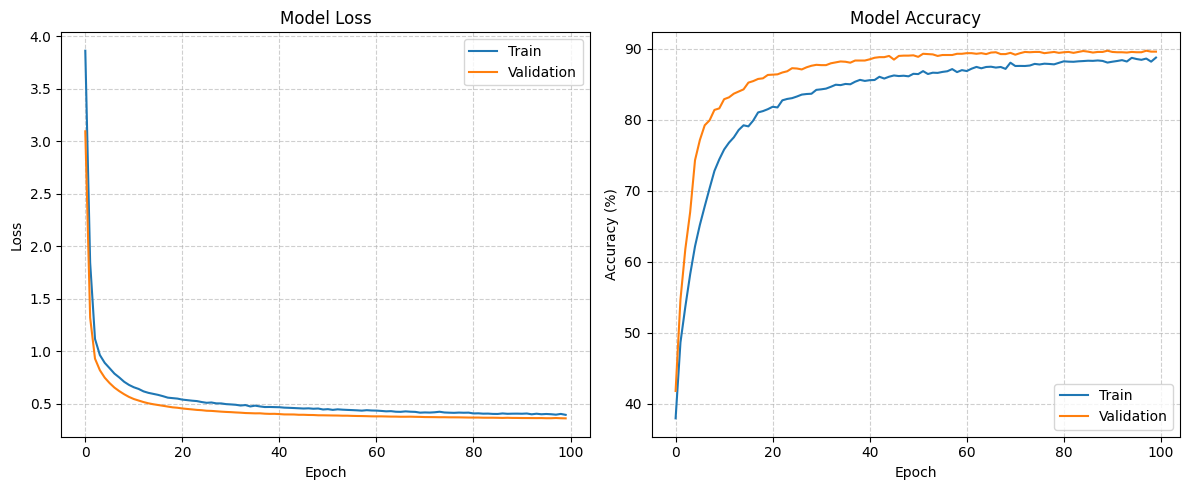

In [103]:
# =============================================================================
# --- 10. לולאת אימון ואימות (Training and Validation Loop) ---
# =============================================================================
print("\n--- 10. Starting Training ---")

# Ensure necessary components exist
if 'model' not in locals() or 'criterion' not in locals() or 'optimizer' not in locals() or \
   'scheduler' not in locals() or 'train_loader' not in locals() or 'val_loader' not in locals() or \
   'device' not in locals() or 'NUM_EPOCHS' not in locals() or 'PATIENCE' not in locals() or \
   'MODEL_SAVE_PATH' not in locals():
    print("Error: One or more required variables/objects for training are missing. Check previous steps.")
    exit()

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_accuracy = 0.0
epochs_no_improve = 0
training_start_time = time.time()

print(f"Training for a maximum of {NUM_EPOCHS} epochs with early stopping patience of {PATIENCE}.")
print(f"Best model will be saved to '{MODEL_SAVE_PATH}'.\n")

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # --- Training Phase ---
    model.train() # Set model to training mode (enables dropout, batchnorm updates)
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Use tqdm for progress bar over batches
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False, unit="batch")

    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients before each batch
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # --- Statistics ---
        running_loss += loss.item() * inputs.size(0) # Accumulate loss scaled by batch size

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1) # Get the index of the max log-probability
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Update progress bar postfix
        train_pbar.set_postfix({'Loss': f"{loss.item():.4f}"})

    # Calculate average loss and accuracy for the epoch
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = 100.0 * correct_train / total_train
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)


    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode (disables dropout, uses running batchnorm stats)
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    # Use tqdm for progress bar over validation batches
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False, unit="batch")

    with torch.no_grad(): # Disable gradient calculations for validation
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            val_pbar.set_postfix({'Loss': f"{loss.item():.4f}"})

    # Calculate average validation loss and accuracy
    # Handle case where val_loader dataset might be empty (though checked earlier)
    epoch_val_loss = running_val_loss / len(val_loader.dataset) if len(val_loader.dataset) > 0 else 0
    epoch_val_acc = 100.0 * correct_val / total_val if total_val > 0 else 0
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)


    # --- LR Scheduling & Epoch Summary ---
    # Get current learning rate BEFORE stepping the scheduler
    current_lr = optimizer.param_groups[0]['lr']
    # Step the scheduler (for StepLR, based on epoch; for ReduceLROnPlateau, based on val_loss)
    scheduler.step(epoch_val_loss) # For ReduceLROnPlateau

    epoch_duration = time.time() - epoch_start_time

    # Print epoch summary
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.1f}s] - LR: {current_lr:.1e} "
          f"- Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}% "
          f"- Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%", end="") # Print initially without newline


    # --- Check for Improvement & Early Stopping ---
    if epoch_val_acc > best_val_accuracy:
        print(f" -> Val Acc Improved! ({best_val_accuracy:.2f}% -> {epoch_val_acc:.2f}%). Saving model...")
        best_val_accuracy = epoch_val_acc
        try:
            # Save the model state dictionary
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
        except Exception as e:
            print(f"\n  Error saving model: {e}")
        epochs_no_improve = 0 # Reset counter
    else:
        epochs_no_improve += 1
        print(f" -> Val Acc No Improve ({epochs_no_improve}/{PATIENCE}). Best: {best_val_accuracy:.2f}%")
        # Check if patience has been exceeded
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs due to no improvement in validation accuracy for {PATIENCE} consecutive epochs.")
            break # Exit the training loop

# --- Training Finished ---
training_duration = time.time() - training_start_time
print(f"\n--- Training Finished ({training_duration / 60:.1f} minutes) ---")
print(f"Best Validation Accuracy achieved: {best_val_accuracy:.2f}%")
if os.path.exists(MODEL_SAVE_PATH):
    print(f"Best model weights saved to: '{MODEL_SAVE_PATH}'")
else:
    print("Warning: Best model file was not saved (possibly due to errors or no improvement).")
print("-" * 30)

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
history_plot_path = os.path.join(PLOT_SAVE_DIR, 'training_history.png')
plt.savefig(history_plot_path)
print(f"Training history plot saved to: {history_plot_path}")


--- 11. Evaluating on Test Set ---
Loading best performing model state from 'best_cnn_model_enhanced.pth'...
Best model loaded successfully.


Evaluating on Test Set:   0%|          | 0/10 [00:00<?, ?batch/s]


--- Test Set Evaluation Results ---

Overall Test Accuracy: 90.58%

Classification Report:
              precision    recall  f1-score   support

         car       0.91      0.85      0.88       504
       human       0.91      0.93      0.92       892
     nothing       0.89      0.91      0.90       917

    accuracy                           0.91      2313
   macro avg       0.91      0.90      0.90      2313
weighted avg       0.91      0.91      0.91      2313


Confusion Matrix:
[[428  24  52]
 [ 11 834  47]
 [ 29  55 833]]



Confusion matrix plot saved to: 'output_plots_enhanced\confusion_matrix_test.png'
------------------------------


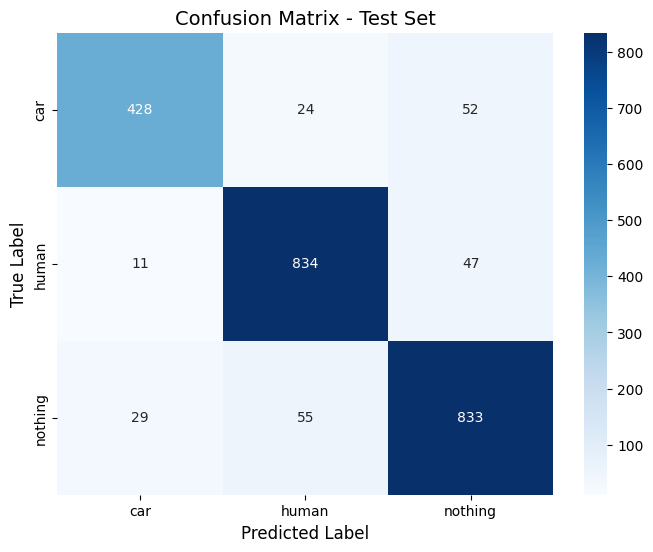

In [105]:
# =============================================================================
# --- 11. הערכה סופית (Final Evaluation on Test Set) ---
# =============================================================================
print("\n--- 11. Evaluating on Test Set ---")

# Ensure necessary components exist
if 'model' not in locals() or 'test_loader' not in locals() or 'device' not in locals() or \
   'MODEL_SAVE_PATH' not in locals() or 'class_names' not in locals():
    print("Error: One or more required variables/objects for evaluation are missing. Check previous steps.")
    exit()

# --- Load the Best Saved Model ---
# Check if the best model file exists
if not os.path.exists(MODEL_SAVE_PATH):
     print(f"Error: Best model file not found at '{MODEL_SAVE_PATH}'.")
     print("Evaluation will be performed with the model's current state (likely the last epoch trained).")
else:
    print(f"Loading best performing model state from '{MODEL_SAVE_PATH}'...")
    try:
        # Load the state dictionary into the existing model structure
        model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device)) # map_location handles loading on CPU if trained on GPU
        print("Best model loaded successfully.")
    except Exception as e:
         print(f"Error loading saved model state from '{MODEL_SAVE_PATH}': {e}.")
         print("Evaluation will be performed with the model's current state.")

# --- Perform Evaluation ---
model.to(device) # Ensure model is on the correct device
model.eval()     # Set model to evaluation mode (important for dropout, batchnorm)

all_preds = []
all_labels = []

eval_pbar = tqdm(test_loader, desc="Evaluating on Test Set", leave=False, unit="batch")

with torch.no_grad(): # Disable gradient calculations during evaluation
    for inputs, labels in eval_pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) # Get the class with the highest probability

        # Store predictions and true labels (move to CPU for sklearn compatibility)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Calculate and Display Metrics ---
if not all_labels or not all_preds:
    print("\nError: No labels or predictions were collected from the test set. Cannot calculate metrics.")
else:
    print("\n--- Test Set Evaluation Results ---")

    # Overall Accuracy
    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Test Accuracy: {test_accuracy * 100.0:.2f}%")

    # Classification Report (Precision, Recall, F1-score per class)
    print("\nClassification Report:")
    # Use zero_division=0 or 1 to handle cases where a class might have no predictions or no true samples
    # Setting to 0 returns 0.0, setting to 1 returns 1.0. 'warn' prints a warning.
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    # Plot Confusion Matrix using Seaborn for better visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix - Test Set', fontsize=14)

    # Save the confusion matrix plot
    cm_save_path = os.path.join(PLOT_SAVE_DIR, "confusion_matrix_test.png")
    try:
        plt.savefig(cm_save_path)
        print(f"\nConfusion matrix plot saved to: '{cm_save_path}'")
    except Exception as e:
        print(f"Error saving confusion matrix plot: {e}")
        plt.show() # Show if saving fails

print("-" * 30)